In [96]:
%load_ext autotime
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')
import time
import os

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score,auc,recall_score,precision_score,precision_recall_curve,confusion_matrix,\
classification_report,roc_auc_score,f1_score

from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 38.1 ms (started: 2024-02-05 17:39:04 +05:30)


In [2]:
master_data = pd.read_pickle('master_data.pkl')

time: 14.7 ms (started: 2024-02-02 19:30:10 +05:30)


In [3]:
master_data.head()

,niro_opportunity_id,month_clearance_status,month_presentation_bucket,prev_month_tat,prev_month_tat_bkt,month_pos,presentation_lag,tenor_in_months,tenor_rank,disbursed_amount,months_since_disb,pf,monthly_income_(net_take_home),monthly_emi,income_rank,state,tier,loan_status,foir,ok/problem_areas,repeat_cases,mobile_no,event,advance_collection_code_month,category,principal_amount,interest_rate,tenure,supply,propensity,offer_type,max_amount,income_source,purpose_of_loan,residence_ownership_type,marital_status,cpv_type,demand,bureau_gender,bureau_pincode,calculated_age,bureau_state,native_language,current_salary,available_income,foir_dlq,foir_cibil,foir_trd,foir_mean,new_foir,naps_disb_score,rnk,max_aggregate_bankcard_utilisation_l12m,cc_util_revolving_l1m,bank_card_payment_category,no_of_60p_accs_ever,no_of_deduped_inquiries,total_cl_open_mortgage_trades_l12m,total_balance_open_mortgage_trades_l12m,total_bal_of_open_pl_l12m,months_since_oldest_trade,no_of_mortgage_trades,no_of_open_cc_trades,no_of_business_general_trades,no_of_30p_accs_ever,no_of_trades,total_bal_open_trades_l12m,total_bal_open_auto_trades_l12m,months_since_recent_chargedoff180p,total_cl_open_auto_trades_l12m,total_cl_open_pl_trades_l12m,no_of_chargedoff180p,total_cl_of_cc_trades_l12m,no_of_90p_accs_ever,total_bal_of_chargedoff_trades,worst_rating_l12m,current_utilization_of_top_wallet_bankcard,no_of_trades_pl_2w_gl_cd,total_bal_open_trades_l12m_except_wo_cc_od,no_of_deduped_inquiries_l12m,no_of_deduped_inquiries_l6m,no_of_deduped_inquiries_l3m,no_of_deduped_inquiries_l1m,worst_rating_l24m,worst_rating_l6m,worst_rating_l3m,worst_rating_l1m,no_of_60p_accs_l24m,no_of_60p_accs_l12m,no_of_trades_bounced_l36m,no_of_trades_bounced_l12m,no_of_cc_trades_60p_l24m,no_of_30p_cc_l24m,no_of_cc_trades_60p_l12m,no_of_30p_cc_l12m,no_of_cc_lt30p_l12m,no_cc_sanctionedamt_lt30k_l36m,no_pl_sanctionedamt_lt30k_l36m,no_tr_opened_l6m,worst_dpd_l36m,total_bal_open_trades_l12m_minus_total_bal_of_chargedoff_trades,no_tr_opened_l12m,no_tr_opened_l3m,per_of_30p_accs_ever,total_payment_amount_bankcard_accs_l3m,max_revolving_monthly_spend_l12m,total_monthly_obligations_l3m,total_balance_bankcard_accs_l3m,no_of_trades_unsec,total_payment_amount_l3m,worst_dpd_l2m,secured_accounts_count,unsecured_accounts_count,secured_high_credit_sum,unsecured_high_credit_sum,secured_amount_overdue_sum,unsecured_amount_overdue_sum,secured_balances_sum,unsecured_balances_sum,own_accounts_count,other_accounts_count,cibil_score,no_of_open_cc_trades_bkt,years_on_bureau_bkt,no_of_deduped_inquiries_bkt,secured_loan_bkt,cust_category,cust_hirisk,cc_inactive,cc_nobc,cc_revolver,cc_rvlrplus,cc_transactor,cc_tranplus,credithungry,naps_new,naps_new_bkt,region,pos_by_la,offered_la_by_disb_la,emi_by_income,naps_diff,mob_by_tenure,interest_rate_bkt
0,8cf95828-6981-4f75-a766-f79769c8bd8a,B) Bounce,E) Bkt 3+,999.0,H) Unpaid,90887.788379,No,18,3,180001,24,0.034993,30000,12295,3,TAMIL NADU,Tier 1,NPA,0.42,Problem Area,1.0,9952744141,1.0,NaN,CAT-C,187754,22,18,quikr,None,PRE_APPROVED,180000,Self Employed,Others,None,SINGLE,None,liquiloans,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.54,99.31,RVLRPLUS,13,69,2737484.0,2363297.0,385903.0,206,2,5,0,14,39,3611695.0,-1.0,6,-1.0,732754.0,13,1210145.0,13,664885.0,9.0,123,22,2749200.0,0,0,0,0,9.0,9.0,9.0,0.0,13,13,39,39,7,17,7,10,12,1,0,0,9.0,2946810.0,0,0,36,41292.0,319656.0,94460.20,1040704.0,22,166578.0,9.0,2,12,2737484.0,2729813.0,26298.0,1124038.0,2363297.0,1426607.0,0,16,652,5+,5+ Yrs,<=1,Secured Loan 7.5L+,Carded 50K+ With Secured Loans,0,0,0,0,1,0,0,0,812,791-818,South,0.504929,0.999994,0.409833,NaN,1.333333,C) 21-24
1,cdf9f121-0176-4ca9-aa9d-f5d4048af74b,B) Bounce,A) Bkt 0,1.0,D) 1-4,12461.921883,No,24,4,125003,23,0.034981,80000,6353,5,ANDHRA PRADESH,Tier 1,Active,0.47,OK Area,1.0,9989185412,0.0,CTB,CAT-C,130385,16,24,quikr,Medium,PRE_APPROVED,150000,Self Employed,Others,None,MARRIED,None,liquiloans,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.00,-2.0

time: 34.8 ms (started: 2024-02-02 19:30:10 +05:30)


In [4]:
master_data.event.value_counts()

event
0.0    3385
1.0    1978
Name: count, dtype: int64

time: 2.82 ms (started: 2024-02-02 19:30:10 +05:30)


##### Bkt 0 cases

In [5]:
# master_data = master_data[master_data.month_presentation_bucket.isin(['A) Bkt 0'])].reset_index(drop=True)

time: 134 µs (started: 2024-02-02 19:30:10 +05:30)


##### Dropping columns

In [6]:
#Columns with all nulls or single value(all 0's)
one_val_cols = [col for col in master_data.columns if len(master_data[col].value_counts().index) <= 1]
#Columns with more than 90% data as null
null_val_cols = [col for col in master_data.columns if sum(master_data[col].isna())/len(master_data) >= 0.90]
master_data.drop(columns = list(set(one_val_cols + null_val_cols)), inplace=True)

time: 84.6 ms (started: 2024-02-02 19:30:11 +05:30)


In [7]:
master_data = master_data[master_data['event'].notna()].copy().reset_index(drop=True)

time: 10.4 ms (started: 2024-02-02 19:30:11 +05:30)


##### Column operations

In [8]:
master_data.head()

,niro_opportunity_id,month_clearance_status,month_presentation_bucket,prev_month_tat,prev_month_tat_bkt,month_pos,presentation_lag,tenor_in_months,tenor_rank,disbursed_amount,months_since_disb,pf,monthly_income_(net_take_home),monthly_emi,income_rank,state,tier,loan_status,foir,ok/problem_areas,repeat_cases,mobile_no,event,advance_collection_code_month,category,principal_amount,interest_rate,tenure,supply,propensity,offer_type,max_amount,income_source,purpose_of_loan,residence_ownership_type,marital_status,cpv_type,demand,bureau_gender,bureau_pincode,calculated_age,bureau_state,native_language,current_salary,available_income,foir_dlq,foir_cibil,foir_trd,foir_mean,new_foir,naps_disb_score,max_aggregate_bankcard_utilisation_l12m,cc_util_revolving_l1m,bank_card_payment_category,no_of_60p_accs_ever,no_of_deduped_inquiries,total_cl_open_mortgage_trades_l12m,total_balance_open_mortgage_trades_l12m,total_bal_of_open_pl_l12m,months_since_oldest_trade,no_of_mortgage_trades,no_of_open_cc_trades,no_of_business_general_trades,no_of_30p_accs_ever,no_of_trades,total_bal_open_trades_l12m,total_bal_open_auto_trades_l12m,months_since_recent_chargedoff180p,total_cl_open_auto_trades_l12m,total_cl_open_pl_trades_l12m,no_of_chargedoff180p,total_cl_of_cc_trades_l12m,no_of_90p_accs_ever,total_bal_of_chargedoff_trades,worst_rating_l12m,current_utilization_of_top_wallet_bankcard,no_of_trades_pl_2w_gl_cd,total_bal_open_trades_l12m_except_wo_cc_od,no_of_deduped_inquiries_l12m,no_of_deduped_inquiries_l6m,no_of_deduped_inquiries_l3m,no_of_deduped_inquiries_l1m,worst_rating_l24m,worst_rating_l6m,worst_rating_l3m,worst_rating_l1m,no_of_60p_accs_l24m,no_of_60p_accs_l12m,no_of_trades_bounced_l36m,no_of_trades_bounced_l12m,no_of_cc_trades_60p_l24m,no_of_30p_cc_l24m,no_of_cc_trades_60p_l12m,no_of_30p_cc_l12m,no_of_cc_lt30p_l12m,no_cc_sanctionedamt_lt30k_l36m,no_pl_sanctionedamt_lt30k_l36m,no_tr_opened_l6m,worst_dpd_l36m,total_bal_open_trades_l12m_minus_total_bal_of_chargedoff_trades,no_tr_opened_l12m,no_tr_opened_l3m,per_of_30p_accs_ever,total_payment_amount_bankcard_accs_l3m,max_revolving_monthly_spend_l12m,total_monthly_obligations_l3m,total_balance_bankcard_accs_l3m,no_of_trades_unsec,total_payment_amount_l3m,worst_dpd_l2m,secured_accounts_count,unsecured_accounts_count,secured_high_credit_sum,unsecured_high_credit_sum,secured_amount_overdue_sum,unsecured_amount_overdue_sum,secured_balances_sum,unsecured_balances_sum,other_accounts_count,cibil_score,no_of_open_cc_trades_bkt,years_on_bureau_bkt,no_of_deduped_inquiries_bkt,secured_loan_bkt,cust_category,cust_hirisk,cc_inactive,cc_nobc,cc_revolver,cc_rvlrplus,cc_transactor,cc_tranplus,credithungry,naps_new,naps_new_bkt,region,pos_by_la,offered_la_by_disb_la,emi_by_income,naps_diff,mob_by_tenure,interest_rate_bkt
0,8cf95828-6981-4f75-a766-f79769c8bd8a,B) Bounce,E) Bkt 3+,999.0,H) Unpaid,90887.788379,No,18,3,180001,24,0.034993,30000,12295,3,TAMIL NADU,Tier 1,NPA,0.42,Problem Area,1.0,9952744141,1.0,NaN,CAT-C,187754,22,18,quikr,None,PRE_APPROVED,180000,Self Employed,Others,None,SINGLE,None,liquiloans,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.54,99.31,RVLRPLUS,13,69,2737484.0,2363297.0,385903.0,206,2,5,0,14,39,3611695.0,-1.0,6,-1.0,732754.0,13,1210145.0,13,664885.0,9.0,123,22,2749200.0,0,0,0,0,9.0,9.0,9.0,0.0,13,13,39,39,7,17,7,10,12,1,0,0,9.0,2946810.0,0,0,36,41292.0,319656.0,94460.20,1040704.0,22,166578.0,9.0,2,12,2737484.0,2729813.0,26298.0,1124038.0,2363297.0,1426607.0,16,652,5+,5+ Yrs,<=1,Secured Loan 7.5L+,Carded 50K+ With Secured Loans,0,0,0,0,1,0,0,0,812,791-818,South,0.504929,0.999994,0.409833,NaN,1.333333,C) 21-24
1,cdf9f121-0176-4ca9-aa9d-f5d4048af74b,B) Bounce,A) Bkt 0,1.0,D) 1-4,12461.921883,No,24,4,125003,23,0.034981,80000,6353,5,ANDHRA PRADESH,Tier 1,Active,0.47,OK Area,1.0,9989185412,0.0,CTB,CAT-C,130385,16,24,quikr,Medium,PRE_APPROVED,150000,Self Employed,Others,None,MARRIED,None,liquiloans,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.00,-2.00,NOBC,0,24,-1.0,-1.0,-1.0,111,0,

time: 39.9 ms (started: 2024-02-02 19:30:11 +05:30)


In [9]:
VarsToDrop = ['niro_opportunity_id', 'demand', 'supply', 'bureau_pincode', 'city', 'mobile_no']
master_data = master_data[master_data.columns[~master_data.columns.isin(VarsToDrop)]]

time: 3.39 ms (started: 2024-02-02 19:30:11 +05:30)


In [10]:
StaticVars = ['event']

time: 191 µs (started: 2024-02-02 19:30:12 +05:30)


In [11]:
for col in master_data.columns:
    if not pd.api.types.is_numeric_dtype(master_data[col]): 
        try:
            master_data[col] = master_data[col].astype(float)
            master_data_oot[col] = master_data_oot[col].astype(float)
        except:
            print(col)

month_clearance_status
month_presentation_bucket
prev_month_tat_bkt
presentation_lag
state
tier
loan_status
ok/problem_areas
advance_collection_code_month
category
propensity
offer_type
income_source
purpose_of_loan
residence_ownership_type
marital_status
cpv_type
bureau_gender
bureau_state
native_language
bank_card_payment_category
no_of_open_cc_trades_bkt
years_on_bureau_bkt
no_of_deduped_inquiries_bkt
secured_loan_bkt
cust_category
naps_new_bkt
region
interest_rate_bkt
time: 4.29 ms (started: 2024-02-02 19:30:12 +05:30)


#### Z-score normalization for numerical fields

In [12]:
master_data.replace(np.inf, 9999999999, inplace=True)

time: 10.9 ms (started: 2024-02-02 19:30:12 +05:30)


In [13]:
numerical_cols = []
for col in master_data.columns:
    if (not pd.api.types.is_object_dtype(master_data[col])) and (col not in ['Event', 'lead_number'] + StaticVars) and (len(np.unique(master_data[col]))>5) and ('frequency' not in col):
        numerical_cols.append(col)

time: 19.7 ms (started: 2024-02-02 19:30:12 +05:30)


In [14]:
from sklearn.preprocessing import StandardScaler
# Perform Z-score normalization on numerical variables
scaler = StandardScaler()
numerical_data_normalized = scaler.fit_transform(master_data.loc[:,numerical_cols])
master_data.loc[:,numerical_cols] = numerical_data_normalized

time: 17.4 ms (started: 2024-02-02 19:30:13 +05:30)


#### Create train test validation split

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
master_data = master_data.sample(frac=1).reset_index(drop=True)
# Split the data into training, validation and testing sets using stratified shuffle split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_val_idx, test_idx = next(sss.split(master_data, master_data[['event', 'month_presentation_bucket']]))
train_val = master_data.iloc[train_val_idx].reset_index(drop=True)
test = master_data.iloc[test_idx].reset_index(drop=True)

# Print the shape of the resulting data
print('Training data shape:', train_val.shape)
print('Train Event % = ', str(train_val.event.mean()))
print('Test data shape:', test.shape)
print('Test Event % = ', str(test.event.mean()))

Training data shape: (3754, 137)
Train Event % =  0.36867341502397444
Test data shape: (1609, 137)
Test Event % =  0.36917339962709755
time: 38.2 ms (started: 2024-02-02 19:30:13 +05:30)


#### Converting categorical field to one hot encoding

##### Also fill null values in categorical field with "Other"

In [16]:
for col in set(train_val.columns):
    if pd.api.types.is_object_dtype(train_val[col]) and (col not in StaticVars):
        print("One hot encoding ", col)

        one_hot = pd.get_dummies(train_val[col], prefix="dummy_"+col, dummy_na=False)
        train_val = pd.concat([train_val, one_hot.iloc[:,:-1]], axis=1)
        train_val.drop(col, axis=1, inplace=True)

        one_hot = pd.get_dummies(test[col], prefix="dummy_"+col, dummy_na=False)
        test = pd.concat([test, one_hot], axis=1)
        test.drop(col, axis=1, inplace=True)

One hot encoding  propensity
One hot encoding  no_of_deduped_inquiries_bkt
One hot encoding  month_presentation_bucket
One hot encoding  bureau_gender
One hot encoding  region
One hot encoding  secured_loan_bkt
One hot encoding  no_of_open_cc_trades_bkt
One hot encoding  state
One hot encoding  tier
One hot encoding  bureau_state
One hot encoding  advance_collection_code_month
One hot encoding  cpv_type
One hot encoding  naps_new_bkt
One hot encoding  years_on_bureau_bkt
One hot encoding  loan_status
One hot encoding  category
One hot encoding  marital_status
One hot encoding  prev_month_tat_bkt
One hot encoding  residence_ownership_type
One hot encoding  offer_type
One hot encoding  native_language
One hot encoding  interest_rate_bkt
One hot encoding  month_clearance_status
One hot encoding  income_source
One hot encoding  presentation_lag
One hot encoding  purpose_of_loan
One hot encoding  ok/problem_areas
One hot encoding  bank_card_payment_category
One hot encoding  cust_category
t

In [17]:
train_val = train_val[list(set(test.columns) & set(train_val.columns))]
test = test[list(set(test.columns) & set(train_val.columns))]

time: 3.86 ms (started: 2024-02-02 19:30:14 +05:30)


In [18]:
train_val.shape, test.shape

((3754, 250), (1609, 250))

time: 2.8 ms (started: 2024-02-02 19:30:14 +05:30)


#### Binning

In [19]:
from optbinning import BinningProcess

(CVXPY) Feb 02 07:30:15 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Feb 02 07:30:15 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
time: 564 ms (started: 2024-02-02 19:30:15 +05:30)


In [20]:
df_train = train_val.copy()
df_test = test.copy()
cat_cols = [col for col in df_train.columns if (((df_train[col].dtype.kind not in 'bifc') or (len(np.unique(df_train[col]))<=2)) and (not (col in StaticVars)))]
# cat_cols = [col for col in df_train.columns if ((len(np.unique(df_train[col]))<=2) and (not (col in StaticVars)))]

time: 22.7 ms (started: 2024-02-02 19:30:15 +05:30)


In [21]:
# binning_fit_params = {
#     "perfios_loan_credit_3m_frequency": {"monotonic_trend": "ascending"},
# }

time: 147 µs (started: 2024-02-02 19:30:16 +05:30)


In [22]:
# abb_cols = [x for x in master_data.columns if ((('abb' in x) or ('minbb' in x)) and ('by' not in x) and ('bkt' not in x) and ('std' not in x) and ('times' not in x))]
# days_balance_less_than_cols = [x for x in master_data.columns if (('days_balance_less_than' in x) and ('bkt' not in x))]
# no_enq_cols = [x for x in master_data.columns if (('no_enq' in x) and ('bkt' not in x))]
# delq_cols = [x for x in master_data.columns if ((('is_' in x) or ('noof_times' in x) or ('pct_' in x)) and ('bkt' not in x))]

time: 265 µs (started: 2024-02-02 19:30:16 +05:30)


In [23]:
# for col in abb_cols:
#     binning_fit_params[col] = {"monotonic_trend": "descending"}

# for col in days_balance_less_than_cols:
#     binning_fit_params[col] = {"monotonic_trend": "ascending"}

# for col in no_enq_cols + delq_cols:
#     binning_fit_params[col] = {"monotonic_trend": "ascending"}

time: 226 µs (started: 2024-02-02 19:30:16 +05:30)


In [24]:
feature_list = df_train.drop(columns=StaticVars).columns.values
binning_process = BinningProcess(categorical_variables=cat_cols, variable_names=feature_list, min_prebin_size = 0.01, max_n_bins=5, min_bin_size = 0.03, special_codes=[9999999999, np.nan], max_pvalue = 0.35, max_pvalue_policy = "consecutive", selection_criteria = { "iv": {"min": 0.02, "strategy": "highest"}}) #, binning_fit_params = binning_fit_params, selection_criteria = { "iv": {"min": 0.02, "strategy": "highest"}, "quality_score": {"min": 0.02}})
binning_process.fit(df_train.drop(columns=StaticVars), df_train['event'])
df_train_binned = binning_process.transform(df_train.drop(columns=StaticVars), metric="bins")
df_test_binned = binning_process.transform(df_test.drop(columns=StaticVars), metric="bins")

df_train_binned_woe = binning_process.transform(df_train.drop(columns=StaticVars), metric="woe")
df_test_binned_woe = binning_process.transform(df_test.drop(columns=StaticVars), metric="woe")

BinningProcess(categorical_variables=['dummy_presentation_lag_No',
                                      'dummy_state_KARNATAKA',
                                      'dummy_advance_collection_code_month_NTB',
                                      'dummy_bureau_gender_Female',
                                      'dummy_state_PONDICHERRY',
                                      'dummy_advance_collection_code_month_FTB',
                                      'dummy_no_of_open_cc_trades_bkt_1-2',
                                      'dummy_tier_Tier 2',
                                      'dummy_purpose_of_loan_To close ongoing '
                                      'loans',
                                      'dummy_prev_month_t...
       'dummy_prev_month_tat_bkt_D) 1-4', 'worst_rating_l3m',
       'dummy_state_GOA', 'dummy_naps_new_bkt_714-728', 'mob_by_tenure',
       'total_cl_of_cc_trades_l12m', 'no_of_cc_trades_60p_l12m',
       'no_tr_opened_l6m', 'dummy_propensity_High',
       'dummy_state_DADRA & NAGAR HAVELI',
       'dummy_advance_collection_code_month_CMU-DPD',
       'dummy_bank_card_payment_category_TRANPLUS',
       'dummy_purpose_of_loan_Business Development'], dtype=object))

time: 12.3 s (started: 2024-02-02 19:30:16 +05:30)


In [25]:
binning_process.information(print_level=2)

optbinning (Version 0.19.0)
Copyright (c) 2019-2024 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    max_n_prebins                         20   * d
    min_prebin_size                     0.01   * U
    min_n_bins                            no   * d
    max_n_bins                             5   * U
    min_bin_size                        0.03   * U
    max_bin_size                          no   * d
    max_pvalue                          0.35   * U
    max_pvalue_policy            consecutive   * d
    selection_criteria                   yes   * U
    fixed_variables                       no   * d
    categorical_variables                yes   * U
    special_codes                        yes   * U
    split_digits                          no   * d
    binning_fit_params                    no   * d
    binning_transform_params              no   * d
    verbose                            False   * d
  End options

  Statistics
    Number of records                   37

In [26]:
df_train_binned.shape

(3754, 121)

time: 831 µs (started: 2024-02-02 19:30:29 +05:30)


In [27]:
feature_list_binned = [(str(x) + '_binned_opt') for x in df_train_binned.columns.values]
feature_list_binned_woe = [(str(x) + '_binned_opt_woe') for x in df_train_binned.columns.values]

time: 274 µs (started: 2024-02-02 19:30:29 +05:30)


In [28]:
train_val = train_val[StaticVars + list(df_train_binned.columns)]
train_val[feature_list_binned] = df_train_binned
train_val[feature_list_binned_woe]= df_train_binned_woe
test = test[StaticVars + list(df_test_binned.columns)]
test[feature_list_binned] = df_test_binned
test[feature_list_binned_woe] = df_test_binned_woe

time: 61.4 ms (started: 2024-02-02 19:30:29 +05:30)


In [29]:
train_val.head()

,event,secured_balances_sum,dummy_advance_collection_code_month_NTB,no_of_60p_accs_l12m,total_balance_open_mortgage_trades_l12m,new_foir,dummy_advance_collection_code_month_FTB,total_bal_open_trades_l12m_except_wo_cc_od,interest_rate,no_of_chargedoff180p,cc_transactor,max_amount,dummy_secured_loan_bkt_Secured Loan 7.5L+,naps_diff,total_bal_open_auto_trades_l12m,total_bal_open_trades_l12m_minus_total_bal_of_chargedoff_trades,cc_tranplus,tenor_in_months,month_pos,worst_dpd_l2m,monthly_emi,dummy_naps_new_bkt_752-770,total_bal_of_chargedoff_trades,dummy_month_presentation_bucket_A) Bkt 0,total_balance_bankcard_accs_l3m,naps_disb_score,available_income,foir_mean,worst_rating_l6m,max_revolving_monthly_spend_l12m,calculated_age,dummy_cust_category_Carded 50K+ With Secured Loans,dummy_bank_card_payment_category_RVLRPLUS,no_of_30p_accs_ever,principal_amount,no_of_60p_accs_l24m,no_of_deduped_inquiries_l3m,no_of_deduped_inquiries_l1m,months_since_oldest_trade,dummy_bank_card_payment_category_NOBC,no_of_open_cc_trades,naps_new,unsecured_high_credit_sum,current_utilization_of_top_wallet_bankcard,no_of_90p_accs_ever,no_of_cc_lt30p_l12m,total_bal_open_trades_l12m,no_of_60p_accs_ever,worst_rating_l12m,foir_cibil,dummy_interest_rate_bkt_C) 21-24,current_salary,worst_rating_l24m,foir_trd,dummy_month_presentation_bucket_B) Bkt 1,tenor_rank,prev_month_tat,dummy_interest_rate_bkt_B) 19-21,no_of_30p_cc_l24m,no_of_deduped_inquiries_l6m,tenure,no_cc_sanctionedamt_lt30k_l36m,no_pl_sanctionedamt_lt30k_l36m,monthly_income_(net_take_home),no_of_cc_trades_60p_l24m,cc_rvlrplus,total_payment_amount_bankcard_accs_l3m,dummy_advance_collection_code_month_OTB-in 3 lm,no_tr_opened_l12m,total_cl_open_mortgage_trades_l12m,per_of_30p_accs_ever,worst_rating_l1m,pf,total_bal_of_open_pl_l12m,dummy_month_presentation_bucket_C) Bkt 2,dummy_month_presentation_bucket_D) Bkt 3,dummy_years_on_bureau_bkt_2-4 Yrs,dummy_no_of_open_cc_trades_bkt_3-4,unsecured_amount_overdue_sum,dummy_ok/problem_areas_OK Area,cc_util_revolving_l1m,dummy_advance_collection_code_month_CTB,dummy_prev_month_tat_bkt_C) 0,no_tr_opened_l3m,income_rank,secured_high_credit_sum,no_of_mortgage_trades,dummy_cust_category_Carded 50K+,total_payment_amount_l3m,secured_amount_overdue_sum,cibil_score,dummy_advance_collection_code_month_NTB-6N,foir,dummy_prev_month_tat_bkt_F) 10 - 20,cc_nobc,worst_dpd_l36m,other_accounts_count,dummy_propensity_Low,dummy_prev_month_tat_bkt_E) 4-10,dummy_loan_status_Active,pos_by_la,emi_by_income,dummy_category_CAT-B,no_of_30p_cc_l12m,dummy_naps_new_bkt_705-713,total_cl_open_pl_trades_l12m,unsecured_balances_sum,max_aggregate_bankcard_utilisation_l12m,months_since_disb,offered_la_by_disb_la,months_since_recent_chargedoff180p,total_cl_open_auto_trades_l12m,disbursed_amount,dummy_prev_month_tat_bkt_D) 1-4,worst_rating_l3m,mob_by_tenure,total_cl_of_cc_trades_l12m,no_of_cc_trades_60p_l12m,no_tr_opened_l6m,dummy_propensity_High,dummy_advance_collection_code_month_CMU-DPD,dummy_bank_card_payment_category_TRANPLUS,secured_balances_sum_binned_opt,dummy_advance_collection_code_month_NTB_binned_opt,no_of_60p_accs_l12m_binned_opt,total_balance_open_mortgage_trades_l12m_binned_opt,new_foir_binned_opt,dummy_advance_collection_code_month_FTB_binned_opt,total_bal_open_trades_l12m_except_wo_cc_od_binned_opt,interest_rate_binned_opt,no_of_chargedoff180p_binned_opt,cc_transactor_binned_opt,max_amount_binned_opt,dummy_secured_loan_bkt_Secured Loan 7.5L+_binned_opt,naps_diff_binned_opt,total_bal_open_auto_trades_l12m_binned_opt,total_bal_open_trades_l12m_minus_total_bal_of_chargedoff_trades_binned_opt,cc_tranplus_binned_opt,tenor_in_months_binned_opt,month_pos_binned_opt,worst_dpd_l2m_binned_opt,monthly_emi_binned_opt,dummy_naps_new_bkt_752-770_binned_opt,total_bal_of_chargedoff_trades_binned_opt,dummy_month_presentation_bucket_A) Bkt 0_binned_opt,total_balance_bankcard_accs_l3m_binned_opt,naps_disb_score_binned_opt,available_income_binned_opt,foir_mean_binned_opt,worst_rating_l6m_binned_opt,max_revol

time: 73.6 ms (started: 2024-02-02 19:30:29 +05:30)


In [30]:
train_val.shape, test.shape

((3754, 364), (1609, 364))

time: 971 µs (started: 2024-02-02 19:30:29 +05:30)


In [31]:
train_val.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3754 entries, 0 to 3753
Data columns (total 364 columns):
 #    Column                                                                          Non-Null Count  Dtype  
---   ------                                                                          --------------  -----  
 0    event                                                                           3754 non-null   float64
 1    secured_balances_sum                                                            3754 non-null   float64
 2    dummy_advance_collection_code_month_NTB                                         3754 non-null   bool   
 3    no_of_60p_accs_l12m                                                             3754 non-null   float64
 4    total_balance_open_mortgage_trades_l12m                                         3754 non-null   float64
 5    new_foir                                                                        3664 non-null   float64
 6    dummy_

In [32]:
summary = binning_process.summary()
summary.head()

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
0,secured_balances_sum,numerical,OPTIMAL,True,5,0.053951,0.0067,0.116224,0.129622
1,dummy_presentation_lag_No,categorical,OPTIMAL,False,2,0.002817,0.000352,0.026469,0.006882
2,dummy_state_KARNATAKA,categorical,OPTIMAL,False,1,0.0,0.0,0,0.0
3,dummy_advance_collection_code_month_NTB,categorical,OPTIMAL,True,2,0.240296,0.025955,0.11123,0.17606
4,no_of_60p_accs_l12m,numerical,OPTIMAL,True,5,1.458992,0.162313,0.573142,0.004566


time: 37.8 ms (started: 2024-02-02 19:30:29 +05:30)


In [33]:
# summary.to_csv('variable_binned_summary.csv', index = False)

time: 193 µs (started: 2024-02-02 19:30:29 +05:30)


In [34]:
summary[summary['status'] == 'INFEASIBLE']

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score


time: 7.97 ms (started: 2024-02-02 19:30:29 +05:30)


#### Distribution Data Prep

In [35]:
# t1 = train_val[['event'] + feature_list_binned + cat_cols]

time: 1.09 ms (started: 2024-02-02 19:30:29 +05:30)


In [36]:
# var_summary = pd.DataFrame()
# for col in t1.columns[1:]:
#     t2 = pd.merge(t1.groupby([col])['event'].count().rename('count'), t1.groupby([col])['event'].sum().astype(int).rename('events'), on = col).reset_index().rename(columns = {col:'buckets'})
#     t2['var_name'] = col
#     t2['non_events'] = t2['count'] - t2['events']
#     t2['event_rate'] = t2['events']/t2['count']
#     t2['non_event_rate'] = t2['non_events']/t2['count']
#     t2['event_prop'] = t2['events'] / sum(t2['events'])
#     t2['non_event_prop'] = t2['non_events'] / sum(t2['non_events'])
#     t2['woe'] = np.log(t2['event_prop'] / t2['non_event_prop'])
#     t2['iv'] = (t2['event_prop'] - t2['non_event_prop']) * t2['woe']
#     var_summary = pd.concat([var_summary, t2])

time: 263 µs (started: 2024-02-02 19:30:29 +05:30)


In [37]:
# var_summary.to_csv('variable_summary.csv')

time: 94.7 µs (started: 2024-02-02 19:30:29 +05:30)


#### Removing raw variables with |correlation| >= 0.9

In [38]:
# calculate correlation matrix
corr_matrix = train_val[[x for x in train_val.columns if (('_binned_opt' not in x) and (x not in StaticVars))]].corr()

# find pairs of variables with correlation 1 or -1
correlated_vars = []
for col in corr_matrix.columns:
    for row in corr_matrix.index:
        if col != row and abs(corr_matrix.loc[row, col]) >= 0.9:
            correlated_vars.append((row, col))

# sort pairs by iv value and drop one variable from each pair
for var1, var2 in correlated_vars:
    if (var1 in summary.name.values) and (var2 in summary.name.values) and (var1 in train_val.columns.values) and (var2 in train_val.columns.values):
        if summary.loc[summary.name == var1, 'iv'].values[0] > summary.loc[summary.name == var2, 'iv'].values[0]:
            print(var1,var2)
            train_val.drop(var2, axis=1, inplace=True)
            test.drop(var2, axis=1, inplace=True)
        else:
            print(var1,var2)
            train_val.drop(var1, axis=1, inplace=True)
            test.drop(var1, axis=1, inplace=True)

total_bal_open_trades_l12m_except_wo_cc_od secured_balances_sum
no_of_30p_accs_ever no_of_60p_accs_l12m
total_cl_open_mortgage_trades_l12m total_balance_open_mortgage_trades_l12m
foir dummy_advance_collection_code_month_FTB
total_bal_open_trades_l12m total_bal_open_trades_l12m_except_wo_cc_od
total_cl_open_auto_trades_l12m total_bal_open_auto_trades_l12m
dummy_bank_card_payment_category_TRANPLUS cc_tranplus
tenor_rank tenor_in_months
tenure tenor_in_months
principal_amount month_pos
disbursed_amount month_pos
prev_month_tat dummy_month_presentation_bucket_A) Bkt 0
current_salary available_income
worst_rating_l12m worst_rating_l6m
worst_rating_l24m worst_rating_l6m
worst_dpd_l36m worst_rating_l6m
worst_rating_l3m worst_rating_l6m
cc_rvlrplus dummy_bank_card_payment_category_RVLRPLUS
no_of_60p_accs_l24m no_of_30p_accs_ever
no_of_60p_accs_ever no_of_30p_accs_ever
cc_nobc dummy_bank_card_payment_category_NOBC
no_of_cc_lt30p_l12m no_of_open_cc_trades
unsecured_balances_sum unsecured_high_cr

#### Removing binned variables with |correlation| >= 0.9

In [39]:
# calculate correlation matrix
corr_matrix = train_val[[x for x in train_val.columns if '_binned_opt_woe' in x]].corr()

# find pairs of variables with correlation 1 or -1
correlated_vars = []
for col in corr_matrix.columns:
    for row in corr_matrix.index:
        if col != row and abs(corr_matrix.loc[row, col]) >= 0.9:
            correlated_vars.append((row, col))

# sort pairs by iv value and drop one variable from each pair
for var1, var2 in correlated_vars:
    var1_temp = "_".join(var1.split('_')[:-3])
    var2_temp = "_".join(var2.split('_')[:-3])

    if (var1_temp in summary.name.values) and (var2_temp in summary.name.values) and (var1 in train_val.columns.values) and (var2 in train_val.columns.values):
        if summary.loc[summary.name == var1_temp, 'iv'].values[0] > summary.loc[summary.name == var2_temp, 'iv'].values[0]:
            print(var1,var2)
            train_val.drop(var2, axis=1, inplace=True)
            test.drop(var2, axis=1, inplace=True)
        else:
            print(var1,var2)
            train_val.drop(var1, axis=1, inplace=True)
            test.drop(var1, axis=1, inplace=True)

no_of_60p_accs_l24m_binned_opt_woe no_of_60p_accs_l12m_binned_opt_woe
no_of_60p_accs_ever_binned_opt_woe no_of_60p_accs_l12m_binned_opt_woe
total_cl_open_mortgage_trades_l12m_binned_opt_woe total_balance_open_mortgage_trades_l12m_binned_opt_woe
months_since_recent_chargedoff180p_binned_opt_woe no_of_chargedoff180p_binned_opt_woe
total_cl_open_auto_trades_l12m_binned_opt_woe total_bal_open_auto_trades_l12m_binned_opt_woe
total_bal_of_chargedoff_trades_binned_opt_woe total_bal_open_trades_l12m_minus_total_bal_of_chargedoff_trades_binned_opt_woe
dummy_bank_card_payment_category_TRANPLUS_binned_opt_woe cc_tranplus_binned_opt_woe
tenor_rank_binned_opt_woe tenor_in_months_binned_opt_woe
tenure_binned_opt_woe tenor_in_months_binned_opt_woe
worst_rating_l12m_binned_opt_woe worst_rating_l6m_binned_opt_woe
worst_rating_l24m_binned_opt_woe worst_rating_l6m_binned_opt_woe
worst_dpd_l36m_binned_opt_woe worst_rating_l6m_binned_opt_woe
worst_rating_l3m_binned_opt_woe worst_rating_l6m_binned_opt_woe
c

In [40]:
# train_val.head()
# train_val.shape

time: 234 µs (started: 2024-02-02 19:30:33 +05:30)


#### Variable Clustering

##### Raw vars

In [48]:
##varclus
from varclushi import VarClusHi
selected_columns = [x for x in train_val.columns if ('_binned_opt' not in x) & (x not in StaticVars)]
vc = VarClusHi(train_val[selected_columns].fillna(0).astype(float),maxeigval2=0.5,maxclus=50)
vc.varclus()
# vc.info
vc.rsquare.sort_values(by = ['Cluster', 'RS_Ratio'])

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
0,0,dummy_bank_card_payment_category_NOBC,0.860105,0.233424,1.824929e-01
5,0,max_aggregate_bankcard_utilisation_l12m,0.834147,0.153650,1.959624e-01
1,0,current_utilization_of_top_wallet_bankcard,0.755599,0.183634,2.993765e-01
2,0,no_cc_sanctionedamt_lt30k_l36m,0.768386,0.231990,3.015768e-01
3,0,cc_util_revolving_l1m,0.555009,0.242439,5.874004e-01
4,0,dummy_cust_category_Carded 50K+,0.496187,0.176630,6.118915e-01
7,1,no_of_30p_accs_ever,0.855875,0.419311,2.481958e-01
8,1,no_of_90p_accs_ever,0.805196,0.572692,4.558871e-01
6,1,worst_dpd_l2m,0.666512,0.291438,4.706547e-01
9,1,no_of_30p_cc_l12m,0.592033,0.345737,6.235518e-01


time: 2.28 s (started: 2024-02-02 19:31:12 +05:30)


In [50]:
cols_to_drop = set(vc.rsquare['Variable'].values) - set(vc.rsquare.sort_values(by = ['Cluster', 'RS_Ratio']).groupby('Cluster').head(4)['Variable'].values)
cols_to_drop

{'cc_util_revolving_l1m',
 'dummy_cust_category_Carded 50K+',
 'monthly_emi',
 'total_payment_amount_bankcard_accs_l3m'}

time: 1.53 s (started: 2024-02-02 19:31:24 +05:30)


In [51]:
train_val.drop(columns = cols_to_drop, inplace=True)
test.drop(columns = cols_to_drop, inplace=True)

time: 18.8 ms (started: 2024-02-02 19:31:29 +05:30)


##### Binned variable

In [52]:
##varclus
from varclushi import VarClusHi
selected_columns = [x for x in train_val.columns if '_binned_opt_woe' in x]
vc = VarClusHi(train_val[selected_columns],maxeigval2=0.5,maxclus=50)
vc.varclus()
# vc.info
vc.rsquare.sort_values(by = ['Cluster', 'RS_Ratio'])

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
2,0,current_salary_binned_opt_woe,0.707028,0.311161,4.253120e-01
3,0,available_income_binned_opt_woe,0.638139,0.210354,4.582577e-01
0,0,monthly_emi_binned_opt_woe,0.660298,0.362510,5.328744e-01
1,0,principal_amount_binned_opt_woe,0.740554,0.646473,7.338781e-01
9,1,worst_rating_l3m_binned_opt_woe,0.881499,0.462995,2.206702e-01
4,1,no_of_60p_accs_l12m_binned_opt_woe,0.865633,0.419050,2.312884e-01
6,1,per_of_30p_accs_ever_binned_opt_woe,0.822807,0.469927,3.342800e-01
7,1,unsecured_amount_overdue_sum_binned_opt_woe,0.800490,0.469014,3.757346e-01
10,1,no_of_90p_accs_ever_binned_opt_woe,0.766645,0.544098,5.118533e-01
8,1,cibil_score_binned_opt_woe,0.680470,0.388695,5.227014e-01


time: 2.87 s (started: 2024-02-02 19:31:34 +05:30)


In [53]:
cols_to_drop = set(vc.rsquare['Variable'].values) - set(vc.rsquare.sort_values(by = ['Cluster', 'RS_Ratio']).groupby('Cluster').head(4)['Variable'].values)
cols_to_drop

{'cibil_score_binned_opt_woe',
 'dummy_cust_category_Carded 50K+ With Secured Loans_binned_opt_woe',
 'dummy_cust_category_Carded 50K+_binned_opt_woe',
 'mob_by_tenure_binned_opt_woe',
 'naps_disb_score_binned_opt_woe',
 'no_of_90p_accs_ever_binned_opt_woe',
 'total_balance_bankcard_accs_l3m_binned_opt_woe',
 'worst_dpd_l2m_binned_opt_woe'}

time: 1.55 s (started: 2024-02-02 19:31:40 +05:30)


In [54]:
train_val.drop(columns = cols_to_drop, inplace=True)
test.drop(columns = cols_to_drop, inplace=True)

time: 15.6 ms (started: 2024-02-02 19:31:49 +05:30)


#### Variable Inflation Factor (VIF) calculation

In [55]:
import statsmodels.api as sm

while True:
    train_val2 = train_val[[x for x in train_val.columns if ('_binned_opt' not in x) & (x not in StaticVars)]].corr().copy()
    # Initialize dataframe to store VIF values
    vif_df = pd.DataFrame(columns=['column', 'VIF'])
    # Loop through columns and calculate VIF values
    for col in (set(train_val2.columns) - set(StaticVars)):
        X = train_val2.drop(col, axis=1)
        y = train_val2[col]
        model = sm.OLS(y, X).fit()
        r_squared = model.rsquared
        vif = 1 / (1 - r_squared)
        vif_df = pd.concat([vif_df, pd.DataFrame.from_dict({'column': [col], 'VIF': [vif]})], ignore_index=True)

    if(len(vif_df[(vif_df['VIF'] >= 10)]) == 0): 
        break

    # Print dataframe
    col_drop = [vif_df[(vif_df['VIF'] >= 10)].sort_values('VIF', ascending=False).column.values[0]]
    print(train_val2.shape, col_drop[0], vif_df.loc[vif_df.column == col_drop[0], 'VIF'].values[0])
    train_val2.drop(columns = col_drop, inplace=True)
    train_val.drop(columns = col_drop, inplace=True)
    test.drop(columns = col_drop, inplace=True)

(90, 90) naps_disb_score 30993976.853668477
(89, 89) max_amount 5606.669617968572
(88, 88) unsecured_balances_sum 4972.147932848666
(87, 87) mob_by_tenure 3597.890208346811
(86, 86) total_cl_of_cc_trades_l12m 1123.229510858276
(85, 85) no_of_30p_accs_ever 1057.7508466650804
(84, 84) month_pos 891.8132560327274
(83, 83) other_accounts_count 805.1712458415587
(82, 82) dummy_bank_card_payment_category_NOBC 719.3376022339415
(81, 81) dummy_advance_collection_code_month_CTB 561.6306611876767
(80, 80) total_bal_open_trades_l12m_except_wo_cc_od 488.11807799562456
(79, 79) prev_month_tat 459.50492870012584
(78, 78) no_of_open_cc_trades 402.8671229222713
(77, 77) unsecured_amount_overdue_sum 345.9726668937665
(76, 76) no_of_deduped_inquiries_l3m 267.6648581651358
(75, 75) no_of_90p_accs_ever 262.83577755263434
(74, 74) interest_rate 205.0661023793923
(73, 73) current_salary 168.23761978087555
(72, 72) tenor_in_months 132.8774975353476
(71, 71) worst_rating_l3m 129.03837444977083
(70, 70) max_ag

In [56]:
import statsmodels.api as sm

while True:
    train_val3 = train_val[[x for x in train_val.columns if '_binned_opt_woe' in x]].corr().copy()
    # Initialize dataframe to store VIF values
    vif_df = pd.DataFrame(columns=['column', 'VIF'])
    # Loop through columns and calculate VIF values

    for col in (set(train_val3.columns) - set(StaticVars)):
        X = train_val3.drop(col, axis=1)
        y = train_val3[col]
        model = sm.OLS(y, X).fit()
        r_squared = model.rsquared
        vif = 1 / (1 - r_squared)
        vif_df = pd.concat([vif_df, pd.DataFrame.from_dict({'column': [col], 'VIF': [vif]})], ignore_index=True)

    if(len(vif_df[(vif_df['VIF'] >= 10)]) == 0): 
        break

    # Print dataframe
    col_drop = [vif_df[(vif_df['VIF'] >= 10)].sort_values('VIF', ascending=False).column.values[0]]
    print(train_val3.shape, col_drop[0], vif_df.loc[vif_df.column == col_drop[0], 'VIF'].values[0])
    train_val3.drop(columns = col_drop, inplace=True)
    train_val.drop(columns = col_drop, inplace=True)
    test.drop(columns = col_drop, inplace=True)

(92, 92) dummy_month_presentation_bucket_A) Bkt 0_binned_opt_woe 3425.7099120853186
(91, 91) dummy_advance_collection_code_month_CTB_binned_opt_woe 1420.9910850289652
(90, 90) no_of_open_cc_trades_binned_opt_woe 1356.6815794687896
(89, 89) tenor_in_months_binned_opt_woe 1017.9782500646154
(88, 88) prev_month_tat_binned_opt_woe 800.0182357780627
(87, 87) principal_amount_binned_opt_woe 609.4045694271312
(86, 86) worst_rating_l3m_binned_opt_woe 462.06812514858086
(85, 85) foir_trd_binned_opt_woe 334.51406449121953
(84, 84) no_of_60p_accs_l12m_binned_opt_woe 287.1685572237605
(83, 83) no_of_30p_cc_l12m_binned_opt_woe 178.74072689913797
(82, 82) max_amount_binned_opt_woe 169.32106969918775
(81, 81) dummy_advance_collection_code_month_CMU-DPD_binned_opt_woe 145.45081947017567
(80, 80) total_payment_amount_bankcard_accs_l3m_binned_opt_woe 122.08936048551607
(79, 79) total_bal_open_trades_l12m_binned_opt_woe 110.83780820662699
(78, 78) max_revolving_monthly_spend_l12m_binned_opt_woe 104.51034

#### Saving data

In [89]:
# train_val.to_pickle('train_val.pkl')
# test.to_pickle('test.pkl')

train_val = pd.read_pickle('train_val.pkl')
test = pd.read_pickle('test.pkl')

time: 36.1 ms (started: 2024-02-05 12:00:30 +05:30)


Model Imports

In [58]:
import statsmodels.api as sm
from sklearn.model_selection import cross_validate

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

time: 93.7 ms (started: 2024-02-02 19:32:50 +05:30)


### Variables type selection

##### Raw values

In [97]:
train_val2 = train_val[[x for x in train_val.columns if '_binned_opt' not in x]]
test2 = test[[x for x in test.columns if '_binned_opt' not in x]]

time: 52 ms (started: 2024-02-05 17:39:24 +05:30)


In [98]:
train_val2.fillna(0, inplace=True)
test2.fillna(0, inplace=True)

time: 17.6 ms (started: 2024-02-05 17:39:24 +05:30)


##### WOE values

In [90]:
train_val2 = train_val[[x for x in train_val.columns if '_binned_opt_woe' in x] + StaticVars]
test2 = test[[x for x in test.columns if '_binned_opt_woe' in x] + StaticVars]

time: 6.62 ms (started: 2024-02-05 12:00:40 +05:30)


### Variable Dropoff

##### a) Drop variables with high p-values

In [99]:
X = train_val2[train_val2.columns[~train_val2.columns.isin(['event'])]] # feature matrix
y = train_val2['event'] # target variable
X = sm.add_constant(X) # add intercept
model = sm.Logit(y, X.astype(float)).fit(method='bfgs', maxiter=100, class_weight='balanced')

# Calculate p-values for each feature
p_values = model.summary2().tables[1]['P>|z|']
# p_values.to_csv('p_vals.csv')

# Load your data and create feature matrix (X) and target variable (y)
while True:
    # Fit logistic regression model with statsmodels
    X = train_val2[train_val2.columns[~train_val2.columns.isin(['event'])]] # feature matrix
    y = train_val2['event'] # target variable
    X = sm.add_constant(X) # add intercept
    model = sm.Logit(y, X.astype(float)).fit(method='bfgs', maxiter=100, class_weight='balanced')

    # Calculate p-values for each feature
    p_values = model.summary2().tables[1]['P>|z|']
    # model.summary2().tables[1].to_csv('p_vals1.csv')
    # Set p-value threshold for feature selection
    p_value_threshold = 0.1

    # Identify features with high p-values and remove them from X
    if len(p_values[p_values > p_value_threshold].index.tolist()) == 0:
        break
    if p_values[p_values > p_value_threshold].index.tolist() == ['const']:
        break
    if p_values.sort_values(ascending=False).index[0] == 'const':
        train_val2 = train_val2.drop(columns = [p_values.sort_values(ascending=False).index[1]])
        test2 = test2.drop(columns = [p_values.sort_values(ascending=False).index[1]])
        print('Dropping ', p_values.sort_values(ascending=False).index[1])
    else:
        train_val2 = train_val2.drop(columns = [p_values.sort_values(ascending=False).index[0]])
        test2 = test2.drop(columns = [p_values.sort_values(ascending=False).index[0]])
        print('Dropping ', p_values.sort_values(ascending=False).index[0])
    print(train_val2.shape, test2.shape)

         Current function value: 0.345134
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
         Current function value: 0.345134
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Dropping  calculated_age
(3754, 52) (1609, 52)
         Current function value: 0.345134
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Dropping  total_cl_open_auto_trades_l12m
(3754, 51) (1609, 51)
         Current function value: 0.345134
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Dropping  total_bal_open_trades_l12m_minus_total_bal_of_chargedoff_trades
(3754, 50) (1609, 50)
         Current function value: 0.345149
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
Dropping  dummy_propensity_High
(3754, 49) (1609, 49)
         Current function value: 0.345170
         Iter

##### b) Drop variable with low Shapley values

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.linear_model import LogisticRegression
# import shap

# def calculate_shapley_values(lr_model, X_train):
#     # Calculate Shapley values for each feature using LinearExplainer
#     explainer = shap.LinearExplainer(lr_model, X_train)
#     shap_values = explainer.shap_values(X_train)

#     # Calculate the absolute Shapley values
#     abs_shap_values = np.abs(shap_values).mean(axis=0)

#     return abs_shap_values

# def select_features_by_shapley(X_train, y_train, shapley_threshold):
#     lr_model = LogisticRegression(random_state=42, class_weight='balanced')
#     lr_model.fit(X_train, y_train)

#     abs_shap_values = calculate_shapley_values(lr_model, X_train)
#     selected_features = X_train.columns[abs_shap_values >= shapley_threshold]

#     return selected_features

# X_train = train_val2[train_val2.columns[~train_val2.columns.isin(['lead_number', 'Event'])]]
# y_train = train_val2['Event']

# # Perform feature selection based on Shapley threshold
# shapley_threshold = 0.001
# selected_features = select_features_by_shapley(X_train, y_train, shapley_threshold)

# print('Selected Features')
# print(selected_features)

# print('Removed features')
# print(set(X_train.columns) - set(selected_features))

# # Update X_train and X_test to include only selected features
# train_val2 = train_val2[list(selected_features) + ['lead_number', 'Event']]
# test2 = test2[list(selected_features) + ['lead_number', 'Event']]

##### c) Boruta Feature Selection

### Cross Validation models

#### GridSearch CV

In [87]:
def kgb_grid_cv_logistic_model(train_val, test, oversample = False, n_components = None):
    # Split the data into training and test sets
    X_train = train_val[train_val.columns[~train_val.columns.isin(['event'])]]
    X_train.shape
    X_test = test[test.columns[~test.columns.isin(['event'])]]
    X_test.shape
    y_train = train_val['event']
    y_train.shape
    y_test = test['event']
    y_test.shape

    lr_param_grid = {
        'penalty': ['l1', 'l2'],
        'C': [0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 4, 6, 8, 10, 25, 50, 75],
        'solver': ['liblinear', 'saga'],
        'max_iter': [2, 5, 7, 10, 15, 20, 25, 50, 60, 90],
    }

    if oversample == True:
        # Oversample the minority class using SMOTE
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)
        X_test, y_test = sm.fit_resample(X_test, y_test)
        lr_model = LogisticRegression(random_state=42)

    else:
        lr_model = LogisticRegression(random_state=42, class_weight='balanced')

    # Apply PCA for dimensionality reduction
    if n_components is not None:
        pca = PCA(n_components=n_components)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)

    gini_scorer = make_scorer(roc_auc_score, needs_proba=True)

    lr_grid = GridSearchCV(lr_model, param_grid=lr_param_grid, cv=5, scoring='roc_auc')
    lr_grid.fit(X_train, y_train)
    lr_model = lr_grid.best_estimator_
    print(lr_grid.best_estimator_)

    # Assuming lr_model is the best estimator obtained from grid search
    coefficients = lr_model.coef_
    intercept = lr_model.intercept_

    # Printing the coefficients
    print("Logistic Regression Coefficients:")
    for feature, coefficient in zip(X_train.columns, coefficients[0]):
        print(f"{feature}: {coefficient}")

    print("\nIntercept (Constant):", intercept[0])

    train_results = []
    for name, model in [('Logistic Regression', lr_model)]:
        train_pred = model.predict(X_train)
        train_prob = model.predict_proba(X_train)[:, 1]
        train_acc = accuracy_score(y_train, train_pred)
        train_prec = precision_score(y_train, train_pred)
        train_recall = recall_score(y_train, train_pred)
        train_f1 = f1_score(y_train, train_pred)
        train_auc = roc_auc_score(y_train, train_prob)
        train_gini = 2 * train_auc - 1
        train_ks_stat = np.max([tpr - fpr for (fpr, tpr, threshold) in zip(*roc_curve(y_train, train_prob))])
        train_cm = confusion_matrix(y_train, train_pred)
        train_results.append({'Model': name, 'Data': 'Train', 'Accuracy': train_acc, 'Precision': train_prec, 'Recall': train_recall, 'F1 Score': train_f1, 'ROC AUC': train_auc, 'Gini': train_gini, 'KS Statistic': train_ks_stat, 'Confusion Matrix': train_cm})

    # Evaluate models on test set
    test_results = []
    for name, model in [('Logistic Regression', lr_model)]:
        test_pred = model.predict(X_test)
        test_prob = model.predict_proba(X_test)[:, 1]
        test_acc = accuracy_score(y_test, test_pred)
        test_prec = precision_score(y_test, test_pred)
        test_recall = recall_score(y_test, test_pred)
        test_f1 = f1_score(y_test, test_pred)
        test_auc = roc_auc_score(y_test, test_prob)
        test_gini = 2 * test_auc - 1
        test_ks_stat = np.max([tpr - fpr for (fpr, tpr, threshold) in zip(*roc_curve(y_test, test_prob))])
        test_cm = confusion_matrix(y_test, test_pred)
        test_results.append({'Model': name, 'Data': 'Test', 'Accuracy': test_acc, 'Precision': test_prec, 'Recall': test_recall, 'F1 Score': test_f1, 'ROC AUC': test_auc, 'Gini': test_gini, 'KS Statistic': test_ks_stat, 'Confusion Matrix': test_cm})

    print("Train Results")
    display(pd.DataFrame(train_results))

    print("Test Results")
    display(pd.DataFrame(test_results))

    return train_gini, test_gini

time: 5.18 ms (started: 2024-02-05 11:54:28 +05:30)


In [62]:
# def kgb_grid_cv_xgb_model(train_val, test, oversample = False, n_components = None, n_features = None):
#     # Split the data into training and test sets
#     X_train = train_val[train_val.columns[~train_val.columns.isin(['lead_number', 'Event'])]]
#     X_train.shape
#     X_test = test[test.columns[~test.columns.isin(['lead_number', 'Event'])]]
#     X_test.shape
#     y_train = train_val['Event']
#     y_train.shape
#     y_test = test['Event']
#     y_test.shape

#     xgb_param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
#               'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.30, 0.4, 0.5, 0.6, 0.7],
#               'max_depth': [5,6,7,8,9,10,11,12,13,14],
#               'n_estimators': [50,65,80,100,115,130,150],
#               'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
#               'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}

#     if oversample == True:
#         # Oversample the minority class using SMOTE
#         sm = SMOTE(random_state=42)
#         X_train, y_train = sm.fit_resample(X_train, y_train)

#         xgb_model = xgb.XGBClassifier(tree_method='gpu_hist', random_state=42)

#     else:
#         xgb_model = xgb.XGBClassifier(tree_method='gpu_hist', random_state=42, scale_pos_weight=20)

#     # Perform Recursive Feature Elimination
#     if n_features is not None:
#         rfe = RFE(estimator=xgb_model, n_features_to_select=n_features)
#         X_train = rfe.fit_transform(X_train, y_train)
#         X_test = rfe.transform(X_test)

#     # Apply PCA for dimensionality reduction
#     if n_components is not None:
#         pca = PCA(n_components=n_components)
#         X_train = pca.fit_transform(X_train)
#         X_test = pca.transform(X_test)

#     xgb_grid = GridSearchCV(xgb_model, param_grid=xgb_param_grid, cv=5, scoring='f1')
#     xgb_grid.fit(X_train, y_train)
#     xgb_model = xgb_grid.best_estimator_
#     print(xgb_grid.best_estimator_)

#     train_results = []
#     for name, model in [('XG Boost', xgb_model)]:
#         train_pred = model.predict(X_train)
#         train_prob = model.predict_proba(X_train)[:, 1]
#         train_acc = accuracy_score(y_train, train_pred)
#         train_prec = precision_score(y_train, train_pred)
#         train_recall = recall_score(y_train, train_pred)
#         train_f1 = f1_score(y_train, train_pred)
#         train_auc = roc_auc_score(y_train, train_prob)
#         train_gini = 2 * train_auc - 1
#         train_ks_stat = np.max([tpr - fpr for (fpr, tpr, threshold) in zip(*roc_curve(y_train, train_prob))])
#         train_cm = confusion_matrix(y_train, train_pred)
#         train_results.append({'Model': name, 'Data': 'Train', 'Accuracy': train_acc, 'Precision': train_prec, 'Recall': train_recall, 'F1 Score': train_f1, 'ROC AUC': train_auc, 'Gini': train_gini, 'KS Statistic': train_ks_stat, 'Confusion Matrix': train_cm})

#     # Evaluate models on test set
#     test_results = []
#     for name, model in [('XG Boost', xgb_model)]:
#         test_pred = model.predict(X_test)
#         test_prob = model.predict_proba(X_test)[:, 1]
#         test_acc = accuracy_score(y_test, test_pred)
#         test_prec = precision_score(y_test, test_pred)
#         test_recall = recall_score(y_test, test_pred)
#         test_f1 = f1_score(y_test, test_pred)
#         test_auc = roc_auc_score(y_test, test_prob)
#         test_gini = 2 * test_auc - 1
#         test_ks_stat = np.max([tpr - fpr for (fpr, tpr, threshold) in zip(*roc_curve(y_test, test_prob))])
#         test_cm = confusion_matrix(y_test, test_pred)
#         test_results.append({'Model': name, 'Data': 'Test', 'Accuracy': test_acc, 'Precision': test_prec, 'Recall': test_recall, 'F1 Score': test_f1, 'ROC AUC': test_auc, 'Gini': test_gini, 'KS Statistic': test_ks_stat, 'Confusion Matrix': test_cm})

#     print("Train Results")
#     display(pd.DataFrame(train_results))

#     print("Test Results")
#     display(pd.DataFrame(test_results))

#     return train_gini, test_gini

time: 1.19 ms (started: 2024-02-02 19:33:04 +05:30)


In [94]:
def kgb_grid_cv_decile_logistic_model(train_val, test, oversample = False, n_components = None, n_deciles = 10):
    # Split the data into training and test sets
    X_train = train_val[train_val.columns[~train_val.columns.isin(['event'])]]
    X_train.shape
    X_test = test[test.columns[~test.columns.isin(['event'])]]
    X_test.shape
    y_train = train_val['event']
    y_train.shape
    y_test = test['event']
    y_test.shape

    lr_param_grid = {
        'penalty': ['l1', 'l2'],
        'C': [0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 4, 6, 8, 10, 25, 50, 75],
        'solver': ['liblinear', 'saga'],
        'max_iter': [2, 5, 7, 10, 15, 20, 25, 50, 60, 90],
    }
    
    if oversample == True:
        # Oversample the minority class using SMOTE
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)
        X_test, y_test = sm.fit_resample(X_test, y_test)
        lr_model = LogisticRegression(random_state=42)

    else:
        lr_model = LogisticRegression(random_state=42, class_weight='balanced')

    # Apply PCA for dimensionality reduction
    if n_components is not None:
        pca = PCA(n_components=n_components)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)

    lr_grid = GridSearchCV(lr_model, param_grid=lr_param_grid, cv=5, scoring='roc_auc')
    lr_grid.fit(X_train, y_train)
    lr_model = lr_grid.best_estimator_
    print(lr_grid.best_estimator_)

    train_results = []
    for name, model in [('Logistic Regression', lr_model)]:
        train_pred = model.predict(X_train)
        train_prob = model.predict_proba(X_train)[:, 1]
        window_size = int(len(train_prob) / n_deciles)
        sorted_prob = np.sort(train_prob)
        deciles = []
        for i in range(n_deciles):
            window_start = i * window_size
            if i == (n_deciles - 1):
                window_end = len(train_prob)-1
                window_indices = np.where(np.logical_and(train_prob >= sorted_prob[window_start], train_prob < sorted_prob[window_end] + 0.001))[0]
            else:
                window_end = int((i+1)*window_size)
                window_indices = np.where(np.logical_and(train_prob >= sorted_prob[window_start], train_prob < sorted_prob[window_end]))[0]
            
            decile_event_rate = np.sum(y_train[window_indices]) / len(window_indices)
            decile_mean_prob = train_prob[window_indices].mean()
            decile_sample_size = len(window_indices)
            deciles.append({'Event Rate': decile_event_rate, 'Sample Size': decile_sample_size})

            window_acc = accuracy_score(y_train[window_indices], train_pred[window_indices])
            window_prec = precision_score(y_train[window_indices], train_pred[window_indices])
            window_recall = recall_score(y_train[window_indices], train_pred[window_indices])
            window_f1 = f1_score(y_train[window_indices], train_pred[window_indices])
            window_auc = roc_auc_score(y_train[window_indices], train_prob[window_indices])
            window_gini = 2 * window_auc - 1
            window_ks_stat = np.max([tpr - fpr for (fpr, tpr, threshold) in zip(*roc_curve(y_train[window_indices], train_prob[window_indices]))])
            window_cm = confusion_matrix(y_train[window_indices], train_pred[window_indices])
            window_prob_range = f"[{round(sorted_prob[window_start], 3)} - {round(sorted_prob[window_end-1], 3)})"
            train_results.append({'Model': name, 'Data': 'Train', 'Window': window_prob_range, 'Population': decile_sample_size, 'Event': np.sum(y_train[window_indices]), 'Non Event': (len(window_indices) - np.sum(y_train[window_indices])), 'Event %': decile_event_rate, 'Non Event %': ((len(window_indices) - np.sum(y_train[window_indices]))/len(window_indices)), 'Mean Probability': decile_mean_prob, 'ROC AUC': window_auc, 'Gini': window_gini, 'KS Statistic': window_ks_stat, 'Confusion Matrix': window_cm})

        train_event_rate = np.sum(y_train) / len(y_train)
        train_mean_prob = train_prob.mean()
        train_sample_size = len(y_train)
        train_acc = accuracy_score(y_train, train_pred)
        train_prec = precision_score(y_train, train_pred)
        train_recall = recall_score(y_train, train_pred)
        train_f1 = f1_score(y_train, train_pred)
        train_auc = roc_auc_score(y_train, train_prob)
        train_gini = 2 * train_auc - 1
        train_ks_stat = np.max([tpr - fpr for (fpr, tpr, threshold) in zip(*roc_curve(y_train, train_prob))])
        train_cm = confusion_matrix(y_train, train_pred)

        train_results.append({'Model': name, 'Data': 'Train', 'Window': 'Overall', 'Population': train_sample_size, 'Event': np.sum(y_train), 'Non Event': (len(y_train) - np.sum(y_train)), 'Event %': train_event_rate, 'Non Event %': ((len(y_train) - np.sum(y_train))/len(y_train)), 'Mean Probability': train_mean_prob, 'ROC AUC': train_auc, 'Gini': train_gini, 'KS Statistic': train_ks_stat, 'Confusion Matrix': train_cm})

        train_results = pd.DataFrame(train_results)
        train_results['% of Event captured'] = train_results['Event']/train_results.loc[n_deciles,'Event']
        train_results['% of Non Event captured'] = train_results['Non Event']/train_results.loc[n_deciles,'Non Event']
        train_results['Cumulative Event'] = train_results['Event'].cumsum()
        train_results['Cumulative Non Event'] = train_results['Non Event'].cumsum()
        train_results['Cumulative Event capture %'] = train_results['% of Event captured'].cumsum()
        train_results['Cumulative Non Event capture %'] = train_results['% of Non Event captured'].cumsum()

        train_results = train_results[['Model', 'Data', 'Window', 'Population', 'Event', 'Non Event', 'Event %', 'Non Event %', '% of Event captured', '% of Non Event captured', 'Cumulative Event', 'Cumulative Non Event', 'Cumulative Event capture %', 'Cumulative Non Event capture %', 'Mean Probability', 'ROC AUC', 'Gini', 'KS Statistic', 'Confusion Matrix']]
        train_results.loc[n_deciles,['Cumulative Event capture %', 'Cumulative Non Event capture %']] = 1
        print("Train Results")
        display(train_results)

        # plot decile-wise event rate
        fig, ax1 = plt.subplots(figsize=(7, 4))
        ax1.plot(list(train_results.loc[:(n_deciles - 1),'Window']), [d['Event Rate'] for d in deciles], 'r.-')
        ax1.set_xlabel('Decile')
        ax1.set_ylabel('Event Rate', color='r')
        ax1.tick_params('y', colors='r')
        plt.xticks(rotation=90)

        # plot decile-wise sample size
        ax2 = ax1.twinx()
        ax2.plot(list(train_results.loc[:(n_deciles - 1),'Window']), list(train_results.loc[:(n_deciles - 1),'Cumulative Event capture %']), color='b', alpha=0.5)
        ax2.set_ylabel('Cumulative Event capture %', color='b')
        ax2.tick_params('y', colors='b')

        plt.xticks(rotation=90)
        plt.legend(loc='upper left')
        plt.title('Train Set')
        plt.show()

    test_results = []
    for name, model in [('Logistic Regression', lr_model)]:
        test_pred = model.predict(X_test)
        test_prob = model.predict_proba(X_test)[:, 1]
        window_size = int(len(train_prob) / n_deciles)
        sorted_prob = np.sort(train_prob)
        deciles = []
        for i in range(n_deciles):
            window_start = i * window_size
            if i == (n_deciles - 1):
                window_end = len(train_prob)-1
                window_indices = np.where(np.logical_and(test_prob >= sorted_prob[window_start], test_prob < sorted_prob[window_end] + 0.001))[0]
            else:
                window_end = int((i+1)*window_size)
                window_indices = np.where(np.logical_and(test_prob >= sorted_prob[window_start], test_prob < sorted_prob[window_end]))[0]
            
            decile_event_rate = np.sum(y_test[window_indices]) / len(window_indices)
            decile_mean_prob = test_prob[window_indices].mean()
            decile_sample_size = len(window_indices)
            deciles.append({'Event Rate': decile_event_rate, 'Sample Size': decile_sample_size})

            window_acc = accuracy_score(y_test[window_indices], test_pred[window_indices])
            window_prec = precision_score(y_test[window_indices], test_pred[window_indices])
            window_recall = recall_score(y_test[window_indices], test_pred[window_indices])
            window_f1 = f1_score(y_test[window_indices], test_pred[window_indices])
            window_auc = roc_auc_score(y_test[window_indices], test_prob[window_indices])
            window_gini = 2 * window_auc - 1
            window_ks_stat = np.max([tpr - fpr for (fpr, tpr, threshold) in zip(*roc_curve(y_test[window_indices], test_prob[window_indices]))])
            window_cm = confusion_matrix(y_test[window_indices], test_pred[window_indices])
            window_prob_range = f"[{round(sorted_prob[window_start], 3)} - {round(sorted_prob[window_end-1], 3)})"
            test_results.append({'Model': name, 'Data': 'Test', 'Window': window_prob_range, 'Population': decile_sample_size, 'Event': np.sum(y_test[window_indices]), 'Non Event': (len(window_indices) - np.sum(y_test[window_indices])), 'Event %': decile_event_rate, 'Non Event %': ((len(window_indices) - np.sum(y_test[window_indices]))/len(window_indices)), 'Mean Probability': decile_mean_prob, 'ROC AUC': window_auc, 'Gini': window_gini, 'KS Statistic': window_ks_stat, 'Confusion Matrix': window_cm})

        test_event_rate = np.sum(y_test) / len(y_test)
        test_mean_prob = test_prob.mean()
        test_sample_size = len(y_test)
        test_acc = accuracy_score(y_test, test_pred)
        test_prec = precision_score(y_test, test_pred)
        test_recall = recall_score(y_test, test_pred)
        test_f1 = f1_score(y_test, test_pred)
        test_auc = roc_auc_score(y_test, test_prob)
        test_gini = 2 * test_auc - 1
        test_ks_stat = np.max([tpr - fpr for (fpr, tpr, threshold) in zip(*roc_curve(y_test, test_prob))])
        test_cm = confusion_matrix(y_test, test_pred)

        test_results.append({'Model': name, 'Data': 'Test', 'Window': 'Overall', 'Population': test_sample_size, 'Event': np.sum(y_test), 'Non Event': (len(y_test) - np.sum(y_test)), 'Event %': test_event_rate, 'Non Event %': ((len(y_test) - np.sum(y_test))/len(y_test)), 'Mean Probability': test_mean_prob, 'ROC AUC': test_auc, 'Gini': test_gini, 'KS Statistic': test_ks_stat, 'Confusion Matrix': test_cm})

        test_results = pd.DataFrame(test_results)
        test_results['% of Event captured'] = test_results['Event']/test_results.loc[n_deciles,'Event']
        test_results['% of Non Event captured'] = test_results['Non Event']/test_results.loc[n_deciles,'Non Event']
        test_results['Cumulative Event'] = test_results['Event'].cumsum()
        test_results['Cumulative Non Event'] = test_results['Non Event'].cumsum()
        test_results['Cumulative Event capture %'] = test_results['% of Event captured'].cumsum()
        test_results['Cumulative Non Event capture %'] = test_results['% of Non Event captured'].cumsum()

        test_results = test_results[['Model', 'Data', 'Window', 'Population', 'Event', 'Non Event', 'Event %', 'Non Event %', '% of Event captured', '% of Non Event captured', 'Cumulative Event', 'Cumulative Non Event', 'Cumulative Event capture %', 'Cumulative Non Event capture %', 'Mean Probability', 'ROC AUC', 'Gini', 'KS Statistic', 'Confusion Matrix']]
        test_results.loc[n_deciles,['Cumulative Event capture %', 'Cumulative Non Event capture %']] = 1
        print("Test Results")
        display(test_results)

        # plot decile-wise event rate
        fig, ax1 = plt.subplots(figsize=(7, 4))
        ax1.plot(list(test_results.loc[:(n_deciles - 1),'Window']), [d['Event Rate'] for d in deciles], 'r.-')
        ax1.set_xlabel('Decile')
        ax1.set_ylabel('Event Rate', color='r')
        ax1.tick_params('y', colors='r')
        plt.xticks(rotation=90)

        # plot decile-wise sample size
        ax2 = ax1.twinx()
        ax2.plot(list(test_results.loc[:(n_deciles - 1),'Window']), list(test_results.loc[:(n_deciles - 1),'Cumulative Event capture %']), color='b', alpha=0.5)
        ax2.set_ylabel('Cumulative Event capture %', color='b')
        ax2.tick_params('y', colors='b')

        plt.legend(loc='upper left')
        plt.title('Test Set')
        plt.show()

time: 7.12 ms (started: 2024-02-05 12:02:40 +05:30)


#### Randomized Search CV

In [64]:
def kgb_rand_cv_logistic_model(train_val, test, oversample = False, n_components = None):
    # Split the data into training and test sets
    X_train = train_val[train_val.columns[~train_val.columns.isin(['event'])]]
    X_train.shape
    X_test = test[test.columns[~test.columns.isin(['event'])]]
    X_test.shape
    y_train = train_val['event']
    y_train.shape
    y_test = test['event']
    y_test.shape

    lr_param_rand = {
        'penalty': ['l1', 'l2'],
        'C': [0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 4, 6, 8, 10, 25, 50, 75],
        'solver': ['liblinear', 'saga'],
        'max_iter': [2, 5, 7, 10, 15, 20, 25, 50, 60, 90],
    }

    feature_names = X_train.columns 

    if oversample == True:
        # Oversample the minority class using SMOTE
        sm = SMOTE(sampling_strategy=0.1, random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)
        # X_test, y_test = sm.fit_resample(X_test, y_test)
        lr_model = LogisticRegression(random_state=42)

    else:
        lr_model = LogisticRegression(random_state=42, class_weight='balanced')

    # Apply PCA for dimensionality reduction
    if n_components is not None:
        pca = PCA(n_components=n_components)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)

    lr_rand = RandomizedSearchCV(lr_model, param_distributions=lr_param_rand, cv=5, scoring='f1', n_iter=500)
    lr_rand.fit(X_train, y_train)
    lr_model = lr_rand.best_estimator_
    print(lr_rand.best_estimator_)

    # coefficients = lr_model.coef_
    # print("Coefficients:", coefficients)


    # # Check if feature names are available
    # if feature_names is not None:
    #     coefficients = lr_model.coef_[0]  # Assuming lr_model is a single-class Logistic Regression
    #     coefficients_mapping = dict(zip(feature_names, coefficients))
        
    #     # Print coefficients mapped to variables
    #     for feature, coefficient in coefficients_mapping.items():
    #         print(f"{feature}: {coefficient}")
    
    train_results = []
    for name, model in [('Logistic Regression', lr_model)]:
        train_pred = model.predict(X_train)
        train_prob = model.predict_proba(X_train)[:, 1]
        train_acc = accuracy_score(y_train, train_pred)
        train_prec = precision_score(y_train, train_pred)
        train_recall = recall_score(y_train, train_pred)
        train_f1 = f1_score(y_train, train_pred)
        train_auc = roc_auc_score(y_train, train_prob)
        train_gini = 2 * train_auc - 1
        train_ks_stat = np.max([tpr - fpr for (fpr, tpr, threshold) in zip(*roc_curve(y_train, train_prob))])
        train_cm = confusion_matrix(y_train, train_pred)
        train_results.append({'Model': name, 'Data': 'Train', 'Accuracy': train_acc, 'Precision': train_prec, 'Recall': train_recall, 'F1 Score': train_f1, 'ROC AUC': train_auc, 'Gini': train_gini, 'KS Statistic': train_ks_stat, 'Confusion Matrix': train_cm})

    # Evaluate models on test set
    test_results = []
    for name, model in [('Logistic Regression', lr_model)]:
        test_pred = model.predict(X_test)
        test_prob = model.predict_proba(X_test)[:, 1]
        test_acc = accuracy_score(y_test, test_pred)
        test_prec = precision_score(y_test, test_pred)
        test_recall = recall_score(y_test, test_pred)
        test_f1 = f1_score(y_test, test_pred)
        test_auc = roc_auc_score(y_test, test_prob)
        test_gini = 2 * test_auc - 1
        test_ks_stat = np.max([tpr - fpr for (fpr, tpr, threshold) in zip(*roc_curve(y_test, test_prob))])
        test_cm = confusion_matrix(y_test, test_pred)
        test_results.append({'Model': name, 'Data': 'Test', 'Accuracy': test_acc, 'Precision': test_prec, 'Recall': test_recall, 'F1 Score': test_f1, 'ROC AUC': test_auc, 'Gini': test_gini, 'KS Statistic': test_ks_stat, 'Confusion Matrix': test_cm})

    print("Train Results")
    display(pd.DataFrame(train_results))

    print("Test Results")
    display(pd.DataFrame(test_results))

    return train_gini, test_gini

time: 2.43 ms (started: 2024-02-02 19:33:07 +05:30)


In [65]:
def kgb_rand_cv_xgb_model(train_val, test, oversample = False, n_components = None):
    # Define a function to remove special characters
    def remove_special_characters(col_name):
        return ''.join(e for e in col_name if e.isalnum() or e.isspace())

    # Apply the function to all column names
    train_val.columns = train_val.columns.map(remove_special_characters)
    test.columns = test.columns.map(remove_special_characters)
    master_data_oot.columns = master_data_oot.columns.map(remove_special_characters)

    # Split the data into training and test sets
    X_train = train_val[train_val.columns[~train_val.columns.isin(['event'])]]
    X_train.shape
    X_test = test[test.columns[~test.columns.isin(['event'])]]
    X_test.shape
    y_train = train_val['event']
    y_train.shape
    y_test = test['event']
    y_test.shape
    
    xgb_param_rand = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
            'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.30, 0.4, 0.5, 0.6, 0.7],
            'max_depth': [5,6,7,8,9,10,11,12,13,14],
            'n_estimators': [50,65,80,100,115,130,150],
            'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
            'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
            'tree_method': ["gpu_hist"]}

    feature_names = X_train.columns 

    if oversample == True:
        # Oversample the minority class using SMOTE
        sm = SMOTE(sampling_strategy=0.1, random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)
        # X_test, y_test = sm.fit_resample(X_test, y_test)
        xgb_model = xgb.XGBClassifier(random_state=42)
    else:
        xgb_model = xgb.XGBClassifier(random_state=42, scale_pos_weight=20)

    # Apply PCA for dimensionality reduction
    if n_components is not None:
        pca = PCA(n_components=n_components)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)

    xgb_rand = RandomizedSearchCV(xgb_model, param_distributions=xgb_param_rand, cv=5, scoring='f1', n_iter=100)
    xgb_rand.fit(X_train, y_train)
    xgb_model = xgb_rand.best_estimator_
    print("XGBoost best parameters", xgb_rand.best_estimator_)
    
    train_results = []
    test_results = []
    for name, model in [('XG Boost', xgb_model)]:
        train_pred = model.predict(X_train)
        train_prob = model.predict_proba(X_train)[:, 1]
        train_acc = accuracy_score(y_train, train_pred)
        train_prec = precision_score(y_train, train_pred)
        train_recall = recall_score(y_train, train_pred)
        train_f1 = f1_score(y_train, train_pred)
        train_auc = roc_auc_score(y_train, train_prob)
        train_gini = 2 * train_auc - 1
        train_ks_stat = np.max([tpr - fpr for (fpr, tpr, threshold) in zip(*roc_curve(y_train, train_prob))])
        train_cm = confusion_matrix(y_train, train_pred)
        train_results.append({'Model': name, 'Data': 'Train', 'Accuracy': train_acc, 'Precision': train_prec, 'Recall': train_recall, 'F1 Score': train_f1, 'ROC AUC': train_auc, 'Gini': train_gini, 'KS Statistic': train_ks_stat, 'Confusion Matrix': train_cm})

        test_pred = model.predict(X_test)
        test_prob = model.predict_proba(X_test)[:, 1]
        test_acc = accuracy_score(y_test, test_pred)
        test_prec = precision_score(y_test, test_pred)
        test_recall = recall_score(y_test, test_pred)
        test_f1 = f1_score(y_test, test_pred)
        test_auc = roc_auc_score(y_test, test_prob)
        test_gini = 2 * test_auc - 1
        test_ks_stat = np.max([tpr - fpr for (fpr, tpr, threshold) in zip(*roc_curve(y_test, test_prob))])
        test_cm = confusion_matrix(y_test, test_pred)
        test_results.append({'Model': name, 'Data': 'Test', 'Accuracy': test_acc, 'Precision': test_prec, 'Recall': test_recall, 'F1 Score': test_f1, 'ROC AUC': test_auc, 'Gini': test_gini, 'KS Statistic': test_ks_stat, 'Confusion Matrix': test_cm})

    print("Train Results")
    display(pd.DataFrame(train_results))

    print("Test Results")
    display(pd.DataFrame(test_results))

time: 2.52 ms (started: 2024-02-02 19:33:08 +05:30)


In [66]:
def kgb_rand_cv_rf_model(train_val, test, oversample = False, n_components = None):
    # Split the data into training and test sets
    X_train = train_val[train_val.columns[~train_val.columns.isin(['event'])]]
    X_train.shape
    X_test = test[test.columns[~test.columns.isin(['event'])]]
    X_test.shape
    y_train = train_val['event']
    y_train.shape
    y_test = test['event']
    y_test.shape
    
    rf_param_rand = {
        'n_estimators': [50, 100, 200, 400, 800, 1600],
        'max_depth': [None, 5, 10, 20, 40, 80],
        'min_samples_split': [2, 5, 10, 20, 40, 80],
        'min_samples_leaf': [1, 2, 4, 8, 16, 32],
        'max_features': ['auto', 'sqrt'],
        'bootstrap': [True, False],
        'max_samples': [None, 0.7, 0.8, 0.9]
    }

    feature_names = X_train.columns 

    if oversample == True:
        # Oversample the minority class using SMOTE
        sm = SMOTE(sampling_strategy=0.1, random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)
        # X_test, y_test = sm.fit_resample(X_test, y_test)
        rf_model = RandomForestClassifier(random_state=42)
    else:
        rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

    # Apply PCA for dimensionality reduction
    if n_components is not None:
        pca = PCA(n_components=n_components)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)

    # Randomized Search for Random Forest
    rf_rand = RandomizedSearchCV(rf_model, param_distributions=rf_param_rand, cv=5, scoring='f1', n_iter=100)
    rf_rand.fit(X_train, y_train)
    rf_model = rf_rand.best_estimator_
    print("Random Forest best parameters", rf_rand.best_estimator_)
    
    train_results = []
    test_results = []
    for name, model in [('Random Forest', rf_model)]:
        train_pred = model.predict(X_train)
        train_prob = model.predict_proba(X_train)[:, 1]
        train_acc = accuracy_score(y_train, train_pred)
        train_prec = precision_score(y_train, train_pred)
        train_recall = recall_score(y_train, train_pred)
        train_f1 = f1_score(y_train, train_pred)
        train_auc = roc_auc_score(y_train, train_prob)
        train_gini = 2 * train_auc - 1
        train_ks_stat = np.max([tpr - fpr for (fpr, tpr, threshold) in zip(*roc_curve(y_train, train_prob))])
        train_cm = confusion_matrix(y_train, train_pred)
        train_results.append({'Model': name, 'Data': 'Train', 'Accuracy': train_acc, 'Precision': train_prec, 'Recall': train_recall, 'F1 Score': train_f1, 'ROC AUC': train_auc, 'Gini': train_gini, 'KS Statistic': train_ks_stat, 'Confusion Matrix': train_cm})

        test_pred = model.predict(X_test)
        test_prob = model.predict_proba(X_test)[:, 1]
        test_acc = accuracy_score(y_test, test_pred)
        test_prec = precision_score(y_test, test_pred)
        test_recall = recall_score(y_test, test_pred)
        test_f1 = f1_score(y_test, test_pred)
        test_auc = roc_auc_score(y_test, test_prob)
        test_gini = 2 * test_auc - 1
        test_ks_stat = np.max([tpr - fpr for (fpr, tpr, threshold) in zip(*roc_curve(y_test, test_prob))])
        test_cm = confusion_matrix(y_test, test_pred)
        test_results.append({'Model': name, 'Data': 'Test', 'Accuracy': test_acc, 'Precision': test_prec, 'Recall': test_recall, 'F1 Score': test_f1, 'ROC AUC': test_auc, 'Gini': test_gini, 'KS Statistic': test_ks_stat, 'Confusion Matrix': test_cm})

    print("Train Results")
    display(pd.DataFrame(train_results))

    print("Test Results")
    display(pd.DataFrame(test_results))

time: 2.39 ms (started: 2024-02-02 19:33:09 +05:30)


In [67]:
def kgb_rand_cv_dt_model(train_val, test, oversample = False, n_components = None):
    # Split the data into training and test sets
    X_train = train_val[train_val.columns[~train_val.columns.isin(['event'])]]
    X_train.shape
    X_test = test[test.columns[~test.columns.isin(['event'])]]
    X_test.shape
    y_train = train_val['event']
    y_train.shape
    y_test = test['event']
    y_test.shape

    dt_param_rand = {
        'max_depth': [None, 5, 10, 20, 40, 80],
        'min_samples_split': [2, 5, 10, 20, 40, 80],
        'min_samples_leaf': [1, 2, 4, 8, 16, 32],
        'max_features': ['auto', 'sqrt'],
        'ccp_alpha': [0.0, 0.005, 0.01, 0.02, 0.05]
    }

    feature_names = X_train.columns 

    if oversample == True:
        # Oversample the minority class using SMOTE
        sm = SMOTE(sampling_strategy=0.1, random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)
        # X_test, y_test = sm.fit_resample(X_test, y_test)
        dt_model = DecisionTreeClassifier(random_state=42)
    else:
        dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

    # Apply PCA for dimensionality reduction
    if n_components is not None:
        pca = PCA(n_components=n_components)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)

    # Randomized Search for Decision Tree
    dt_rand = RandomizedSearchCV(dt_model, param_distributions=dt_param_rand, cv=5, scoring='f1', n_iter=100)
    dt_rand.fit(X_train, y_train)
    dt_model = dt_rand.best_estimator_
    print("Decision Tree best parameters", dt_rand.best_estimator_)
    
    train_results = []
    test_results = []
    for name, model in [('Decision Tree', dt_model)]:
        train_pred = model.predict(X_train)
        train_prob = model.predict_proba(X_train)[:, 1]
        train_acc = accuracy_score(y_train, train_pred)
        train_prec = precision_score(y_train, train_pred)
        train_recall = recall_score(y_train, train_pred)
        train_f1 = f1_score(y_train, train_pred)
        train_auc = roc_auc_score(y_train, train_prob)
        train_gini = 2 * train_auc - 1
        train_ks_stat = np.max([tpr - fpr for (fpr, tpr, threshold) in zip(*roc_curve(y_train, train_prob))])
        train_cm = confusion_matrix(y_train, train_pred)
        train_results.append({'Model': name, 'Data': 'Train', 'Accuracy': train_acc, 'Precision': train_prec, 'Recall': train_recall, 'F1 Score': train_f1, 'ROC AUC': train_auc, 'Gini': train_gini, 'KS Statistic': train_ks_stat, 'Confusion Matrix': train_cm})

        test_pred = model.predict(X_test)
        test_prob = model.predict_proba(X_test)[:, 1]
        test_acc = accuracy_score(y_test, test_pred)
        test_prec = precision_score(y_test, test_pred)
        test_recall = recall_score(y_test, test_pred)
        test_f1 = f1_score(y_test, test_pred)
        test_auc = roc_auc_score(y_test, test_prob)
        test_gini = 2 * test_auc - 1
        test_ks_stat = np.max([tpr - fpr for (fpr, tpr, threshold) in zip(*roc_curve(y_test, test_prob))])
        test_cm = confusion_matrix(y_test, test_pred)
        test_results.append({'Model': name, 'Data': 'Test', 'Accuracy': test_acc, 'Precision': test_prec, 'Recall': test_recall, 'F1 Score': test_f1, 'ROC AUC': test_auc, 'Gini': test_gini, 'KS Statistic': test_ks_stat, 'Confusion Matrix': test_cm})

    print("Train Results")
    display(pd.DataFrame(train_results))

    print("Test Results")
    display(pd.DataFrame(test_results))

time: 2.79 ms (started: 2024-02-02 19:33:09 +05:30)


### Logistic model

##### Model Run

In [100]:
kgb_grid_cv_logistic_model(train_val2, test2, oversample = False, n_components = None)

LogisticRegression(C=1, class_weight='balanced', max_iter=90, random_state=42,
                   solver='saga')
Logistic Regression Coefficients:
dummy_advance_collection_code_month_NTB: -1.5516445300304016
cc_transactor: -0.5066252190006283
naps_diff: 0.17239576647870278
cc_tranplus: -0.7752183496300284
worst_dpd_l2m: 0.19260998355546205
foir_mean: 0.08804410089619415
max_revolving_monthly_spend_l12m: 0.17494569276012023
dummy_cust_category_Carded 50K+ With Secured Loans: -0.4059353771564847
dummy_bank_card_payment_category_RVLRPLUS: -0.39815013493526125
no_of_deduped_inquiries_l1m: -0.18523809781779868
foir_cibil: 0.7373431352146963
dummy_interest_rate_bkt_C) 21-24: 0.33435819997162763
dummy_month_presentation_bucket_B) Bkt 1: 1.1970059203098227
no_pl_sanctionedamt_lt30k_l36m: 0.12131971568599642
dummy_advance_collection_code_month_OTB-in 3 lm: -1.1037557009242351
worst_rating_l1m: 0.11768920847420036
pf: 0.16230074403327047
dummy_month_presentation_bucket_C) Bkt 2: 1.72698183615867

,Model,Data,Accuracy,Precision,Recall,F1 Score,ROC AUC,Gini,KS Statistic,Confusion Matrix
0,Logistic Regression,Train,0.864944,0.800137,0.844653,0.821793,0.912439,0.824879,0.723256,"[[2078, 292], [215, 1169]]"


Test Results


,Model,Data,Accuracy,Precision,Recall,F1 Score,ROC AUC,Gini,KS Statistic,Confusion Matrix
0,Logistic Regression,Test,0.862026,0.792453,0.848485,0.819512,0.909073,0.818145,0.72537,"[[883, 132], [90, 504]]"


(0.824878661496061, 0.8181453284901565)

time: 52.8 s (started: 2024-02-05 17:40:21 +05:30)


LogisticRegression(C=1, class_weight='balanced', max_iter=90, random_state=42,
                   solver='saga')
Train Results


,Model,Data,Window,Population,Event,Non Event,Event %,Non Event %,% of Event captured,% of Non Event captured,Cumulative Event,Cumulative Non Event,Cumulative Event capture %,Cumulative Non Event capture %,Mean Probability,ROC AUC,Gini,KS Statistic,Confusion Matrix
0,Logistic Regression,Train,[0.001 - 0.065),375,16.0,359.0,0.042667,0.957333,0.011561,0.151477,16.0,359.0,0.011561,0.151477,0.042234,0.495822,-0.008357,0.111247,"[[359, 0], [16, 0]]"
1,Logistic Regression,Train,[0.066 - 0.098),375,14.0,361.0,0.037333,0.962667,0.010116,0.152321,30.0,720.0,0.021676,0.303797,0.081625,0.475861,-0.048279,0.125841,"[[361, 0], [14, 0]]"
2,Logistic Regression,Train,[0.098 - 0.134),375,33.0,342.0,0.088000,0.912000,0.023844,0.144304,63.0,1062.0,0.045520,0.448101,0.115668,0.529151,0.058302,0.153642,"[[342, 0], [33, 0]]"
3,Logistic Regression,Train,[0.134 - 0.181),375,29.0,346.0,0.077333,0.922667,0.020954,0.145992,92.0,1408.0,0.066474,0.594093,0.156446,0.615806,0.231613,0.278254,"[[346, 0], [29, 0]]"
4,Logistic Regression,Train,[0.181 - 0.268),375,43.0,332.0,0.114667,0.885333,0.031069,0.140084,135.0,1740.0,0.097543,0.734177,0.216050,0.500911,0.001821,0.070818,"[[332, 0], [43, 0]]"
5,Logistic Regression,Train,[0.268 - 0.464),375,69.0,306.0,0.184000,0.816000,0.049855,0.129114,204.0,2046.0,0.147399,0.863291,0.355183,0.643743,0.287487,0.255044,"[[306, 0], [69, 0]]"
6,Logistic Regression,Train,[0.464 - 0.736),375,200.0,175.0,0.533333,0.466667,0.144509,0.073840,404.0,2221.0,0.291908,0.937131,0.610819,0.687457,0.374914,0.324286,"[[32, 143], [11, 189]]"
7,Logistic Regression,Train,[0.737 - 0.877),375,280.0,95.0,0.746667,0.253333,0.202312,0.040084,684.0,2316.0,0.494220,0.977215,0.810193,0.547594,0.095188,0.139098,"[[0, 95], [0, 280]]"
8,Logistic Regression,Train,[0.878 - 0.951),375,337.0,38.0,0.898667,0.101333,0.243497,0.016034,1021.0,2354.0,0.737717,0.993249,0.919516,0.549898,0.099797,0.166094,"[[0, 38], [0, 337]]"
9,Logistic Regression,Train,[0.951 - 0.999),379,363.0,16.0,0.957784,0.042216,0.262283,0.006751,1384.0,2370.0,1.000000,1.000000,0.971356,0.481405,-0.037190,0.159435,"[[0, 16], [0, 363]]"


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


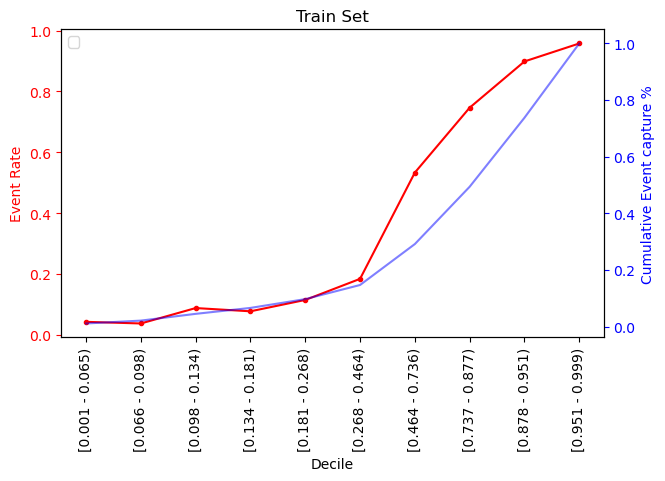

Test Results


,Model,Data,Window,Population,Event,Non Event,Event %,Non Event %,% of Event captured,% of Non Event captured,Cumulative Event,Cumulative Non Event,Cumulative Event capture %,Cumulative Non Event capture %,Mean Probability,ROC AUC,Gini,KS Statistic,Confusion Matrix
0,Logistic Regression,Test,[0.001 - 0.065),169,14.0,155.0,0.082840,0.917160,0.023569,0.152709,14.0,155.0,0.023569,0.152709,0.042712,0.600000,0.200000,0.294009,"[[155, 0], [14, 0]]"
1,Logistic Regression,Test,[0.066 - 0.098),153,8.0,145.0,0.052288,0.947712,0.013468,0.142857,22.0,300.0,0.037037,0.295567,0.082247,0.621552,0.243103,0.300862,"[[145, 0], [8, 0]]"
2,Logistic Regression,Test,[0.098 - 0.134),143,10.0,133.0,0.069930,0.930070,0.016835,0.131034,32.0,433.0,0.053872,0.426601,0.115616,0.483459,-0.033083,0.141353,"[[133, 0], [10, 0]]"
3,Logistic Regression,Test,[0.134 - 0.181),156,4.0,152.0,0.025641,0.974359,0.006734,0.149754,36.0,585.0,0.060606,0.576355,0.154894,0.129934,-0.740132,0.052632,"[[152, 0], [4, 0]]"
4,Logistic Regression,Test,[0.181 - 0.268),161,15.0,146.0,0.093168,0.906832,0.025253,0.143842,51.0,731.0,0.085859,0.720197,0.218476,0.472603,-0.054795,0.118265,"[[146, 0], [15, 0]]"
5,Logistic Regression,Test,[0.268 - 0.464),172,37.0,135.0,0.215116,0.784884,0.062290,0.133005,88.0,866.0,0.148148,0.853202,0.356699,0.632633,0.265265,0.219419,"[[135, 0], [37, 0]]"
6,Logistic Regression,Test,[0.464 - 0.736),180,87.0,93.0,0.483333,0.516667,0.146465,0.091626,175.0,959.0,0.294613,0.944828,0.610770,0.669139,0.338277,0.292176,"[[17, 76], [2, 85]]"
7,Logistic Regression,Test,[0.737 - 0.877),151,120.0,31.0,0.794702,0.205298,0.202020,0.030542,295.0,990.0,0.496633,0.975369,0.817107,0.539785,0.079570,0.171505,"[[0, 31], [0, 120]]"
8,Logistic Regression,Test,[0.878 - 0.951),165,143.0,22.0,0.866667,0.133333,0.240741,0.021675,438.0,1012.0,0.737374,0.997044,0.918183,0.549905,0.099809,0.195804,"[[0, 22], [0, 143]]"
9,Logistic Regression,Test,[0.951 - 0.999),159,156.0,3.0,0.981132,0.018868,0.262626,0.002956,594.0,1015.0,1.000000,1.000000,0.971827,0.724359,0.448718,0.596154,"[[0, 3], [0, 156]]"


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


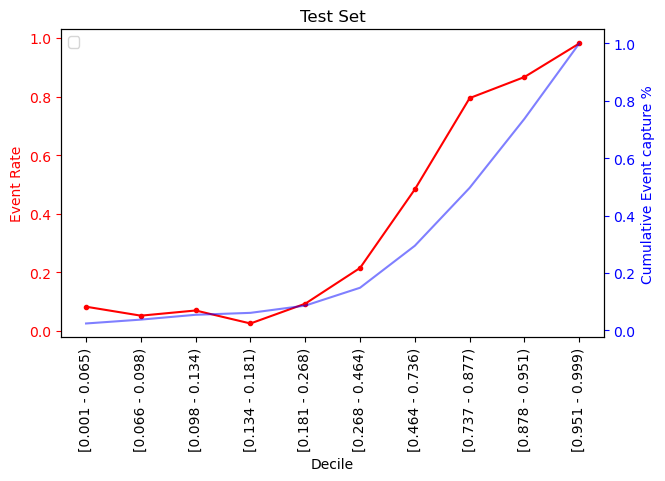

time: 52.8 s (started: 2024-02-05 17:41:14 +05:30)


In [101]:
kgb_grid_cv_decile_logistic_model(train_val2, test2, oversample = False, n_components = None, n_deciles = 10)

### All models

In [104]:
import statsmodels.api as sm
from sklearn.model_selection import cross_validate

time: 1.31 ms (started: 2024-02-05 17:54:25 +05:30)


In [105]:
train_val2 = train_val[[x for x in train_val.columns if '_binned_opt' not in x]]
test2 = test[[x for x in test.columns if '_binned_opt' not in x]]

train_val2.fillna(0, inplace=True)
test2.fillna(0, inplace=True)

# train_val2 = train_val[StaticVars + [x for x in train_val.columns if '_binned_opt_woe' in x]]
# test2 = test[StaticVars + [x for x in test.columns if '_binned_opt_woe' in x]]

time: 13.9 ms (started: 2024-02-05 17:54:26 +05:30)


In [106]:
# Define a function to remove special characters
def remove_special_characters(col_name):
    return ''.join(e for e in col_name if e.isalnum() or e.isspace())

# Apply the function to all column names
train_val2.columns = train_val2.columns.map(remove_special_characters)
test2.columns = test2.columns.map(remove_special_characters)

time: 2.48 ms (started: 2024-02-05 17:54:28 +05:30)


In [107]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve

from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV

def kgb_rand_cv_all_model(train_val, test, oversample = False, n_components = None):
    # Split the data into training and test sets
    X_train = train_val[train_val.columns[~train_val.columns.isin(['event'])]]
    X_train.shape
    X_test = test[test.columns[~test.columns.isin(['event'])]]
    X_test.shape
    y_train = train_val['event']
    y_train.shape
    y_test = test['event']
    y_test.shape

    lr_param_rand = {
        'penalty': ['l1', 'l2'],
        'C': [0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 4, 6, 8, 10, 25, 50, 75],
        'solver': ['liblinear', 'saga'],
        'max_iter': [2, 5, 7, 10, 15, 20, 25, 50, 60, 90],
    }

    xgb_param_rand = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
            'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.30, 0.4, 0.5, 0.6, 0.7],
            'max_depth': [5,6,7,8,9,10,11,12,13,14],
            'n_estimators': [50,65,80,100,115,130,150],
            'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
            'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}
    
    rf_param_rand = {
        'n_estimators': [50, 100, 200, 400, 800, 1600],
        'max_depth': [None, 5, 10, 20, 40, 80],
        'min_samples_split': [2, 5, 10, 20, 40, 80],
        'min_samples_leaf': [1, 2, 4, 8, 16, 32],
        'max_features': ['auto', 'sqrt'],
        'bootstrap': [True, False],
        'max_samples': [None, 0.7, 0.8, 0.9]
    }

    dt_param_rand = {
        'max_depth': [None, 5, 10, 20, 40, 80],
        'min_samples_split': [2, 5, 10, 20, 40, 80],
        'min_samples_leaf': [1, 2, 4, 8, 16, 32],
        'max_features': ['auto', 'sqrt'],
        'ccp_alpha': [0.0, 0.005, 0.01, 0.02, 0.05]
    }

    feature_names = X_train.columns 

    if oversample == True:
        # Oversample the minority class using SMOTE
        sm = SMOTE(sampling_strategy=0.1, random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)
        # X_test, y_test = sm.fit_resample(X_test, y_test)
        lr_model = LogisticRegression(random_state=42)
        xgb_model = xgb.XGBClassifier(random_state=42)
        rf_model = RandomForestClassifier(random_state=42)
        dt_model = DecisionTreeClassifier(random_state=42)
    else:
        lr_model = LogisticRegression(random_state=42, class_weight='balanced')
        xgb_model = xgb.XGBClassifier(random_state=42, scale_pos_weight=20)
        rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
        dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

    # Apply PCA for dimensionality reduction
    if n_components is not None:
        pca = PCA(n_components=n_components)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)

    lr_rand = RandomizedSearchCV(lr_model, param_distributions=lr_param_rand, cv=5, scoring='f1', n_iter=500)
    lr_rand.fit(X_train, y_train)
    lr_model = lr_rand.best_estimator_
    print("Logistic best parameters", lr_rand.best_estimator_)

    xgb_rand = RandomizedSearchCV(xgb_model, param_distributions=xgb_param_rand, cv=5, scoring='f1', n_iter=100)
    xgb_rand.fit(X_train, y_train)
    xgb_model = xgb_rand.best_estimator_
    print("XGBoost best parameters", xgb_rand.best_estimator_)

    # Randomized Search for Random Forest
    rf_rand = RandomizedSearchCV(rf_model, param_distributions=rf_param_rand, cv=5, scoring='f1', n_iter=100)
    rf_rand.fit(X_train, y_train)
    rf_model = rf_rand.best_estimator_
    print("Random Forest best parameters", rf_rand.best_estimator_)

    # Randomized Search for Decision Tree
    dt_rand = RandomizedSearchCV(dt_model, param_distributions=dt_param_rand, cv=5, scoring='f1', n_iter=100)
    dt_rand.fit(X_train, y_train)
    dt_model = dt_rand.best_estimator_
    print("Decision Tree best parameters", dt_rand.best_estimator_)
    
    train_results = []
    test_results = []
    for name, model in [('Logistic Regression', lr_model), ('XG Boost', xgb_model), ('Random Forest', rf_model), ('Decision Tree', dt_model)]:
        train_pred = model.predict(X_train)
        train_prob = model.predict_proba(X_train)[:, 1]
        train_acc = accuracy_score(y_train, train_pred)
        train_prec = precision_score(y_train, train_pred)
        train_recall = recall_score(y_train, train_pred)
        train_f1 = f1_score(y_train, train_pred)
        train_auc = roc_auc_score(y_train, train_prob)
        train_gini = 2 * train_auc - 1
        train_ks_stat = np.max([tpr - fpr for (fpr, tpr, threshold) in zip(*roc_curve(y_train, train_prob))])
        train_cm = confusion_matrix(y_train, train_pred)
        train_results.append({'Model': name, 'Data': 'Train', 'Accuracy': train_acc, 'Precision': train_prec, 'Recall': train_recall, 'F1 Score': train_f1, 'ROC AUC': train_auc, 'Gini': train_gini, 'KS Statistic': train_ks_stat, 'Confusion Matrix': train_cm})

        test_pred = model.predict(X_test)
        test_prob = model.predict_proba(X_test)[:, 1]
        test_acc = accuracy_score(y_test, test_pred)
        test_prec = precision_score(y_test, test_pred)
        test_recall = recall_score(y_test, test_pred)
        test_f1 = f1_score(y_test, test_pred)
        test_auc = roc_auc_score(y_test, test_prob)
        test_gini = 2 * test_auc - 1
        test_ks_stat = np.max([tpr - fpr for (fpr, tpr, threshold) in zip(*roc_curve(y_test, test_prob))])
        test_cm = confusion_matrix(y_test, test_pred)
        test_results.append({'Model': name, 'Data': 'Test', 'Accuracy': test_acc, 'Precision': test_prec, 'Recall': test_recall, 'F1 Score': test_f1, 'ROC AUC': test_auc, 'Gini': test_gini, 'KS Statistic': test_ks_stat, 'Confusion Matrix': test_cm})

    print("Train Results")
    display(pd.DataFrame(train_results))

    print("Test Results")
    display(pd.DataFrame(test_results))

time: 9.26 ms (started: 2024-02-05 17:54:28 +05:30)


In [108]:
kgb_rand_cv_all_model(train_val2, test2, oversample = False, n_components = None)

Logistic best parameters LogisticRegression(C=8, class_weight='balanced', max_iter=10, penalty='l1',
                   random_state=42, solver='liblinear')
XGBoost best parameters XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.25, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
Random Forest best parameters RandomForestClassifier(bootstrap=False,

,Model,Data,Accuracy,Precision,Recall,F1 Score,ROC AUC,Gini,KS Statistic,Confusion Matrix
0,Logistic Regression,Train,0.863879,0.798360,0.843931,0.820513,0.914133,0.828265,0.722464,"[[2075, 295], [216, 1168]]"
1,XG Boost,Train,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,"[[2370, 0], [0, 1384]]"
2,Random Forest,Train,0.937666,0.914863,0.916185,0.915523,0.989283,0.978566,0.888651,"[[2252, 118], [116, 1268]]"
3,Decision Tree,Train,0.798082,0.746069,0.685694,0.714608,0.820941,0.641883,0.549407,"[[2047, 323], [435, 949]]"


Test Results


,Model,Data,Accuracy,Precision,Recall,F1 Score,ROC AUC,Gini,KS Statistic,Confusion Matrix
0,Logistic Regression,Test,0.862648,0.793701,0.848485,0.820179,0.910607,0.821214,0.728077,"[[884, 131], [90, 504]]"
1,XG Boost,Test,0.861405,0.784946,0.860269,0.820884,0.917648,0.835295,0.723697,"[[875, 140], [83, 511]]"
2,Random Forest,Test,0.869484,0.822148,0.824916,0.823529,0.919962,0.839923,0.722290,"[[909, 106], [104, 490]]"
3,Decision Tree,Test,0.794282,0.732743,0.696970,0.714409,0.821664,0.643328,0.548201,"[[864, 151], [180, 414]]"


time: 7min 10s (started: 2024-02-05 17:54:29 +05:30)
